In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#데이터 분석


In [ ]:
display(df_grouped)

,주제분류_bin,대출건수
0,0-99,194436
1,100-199,234175
2,200-299,121540
3,300-399,674048
4,400-499,552651
5,500-599,359328
6,600-699,218383
7,700-799,246471
8,800-899,3426255


/tmp/ipython-input-1245211158.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='주제분류_bin', y='대출건수', data=df_grouped, palette='viridis')


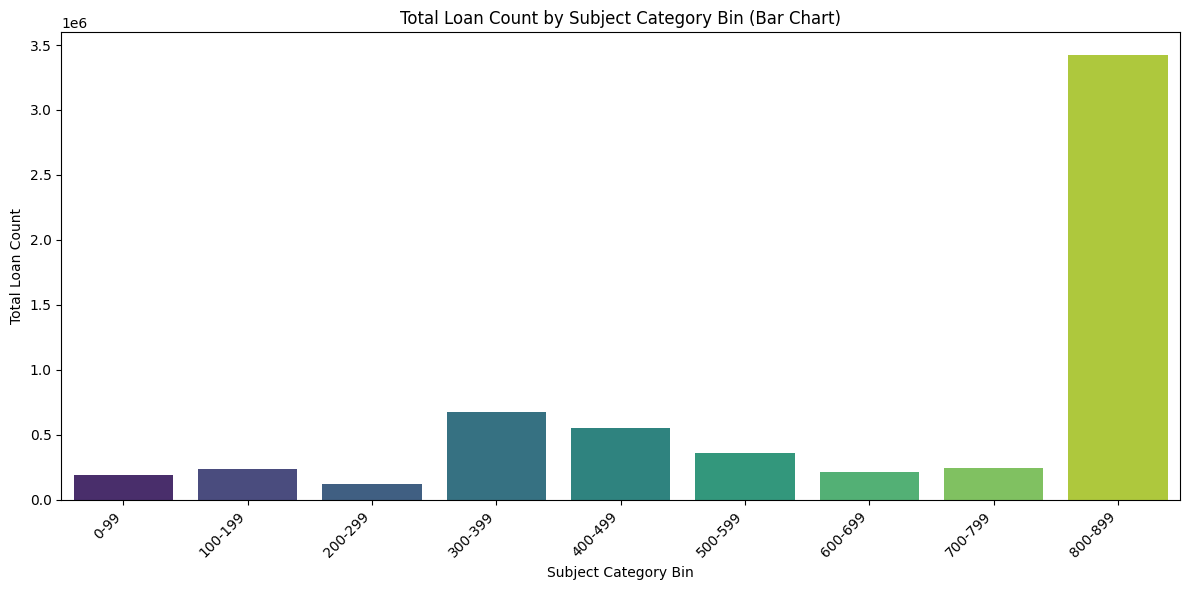

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='주제분류_bin', y='대출건수', data=df_grouped, palette='viridis')
plt.title('Total Loan Count by Subject Category Bin (Bar Chart)')
plt.xlabel('Subject Category Bin')
plt.ylabel('Total Loan Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

이프로그램을 통해서 도서관 사람들이 더 유입될수 있다.라는것에 근거를 가지기 위해 유의미한 데이터 추출 및 분석 필요


#데이터 전처리 및 파이프라인

필요한 데이터를 어느정도 전처리과정만하고
전처리한 데이터로 LLM 검색 api사용해서 그걸로 카테고리화를 한다.

In [ ]:
!pip install pandas langchain langchain-openai langchain-community tavily-python

In [ ]:
!pip install langchain-tavily

In [ ]:
!pip install pandas langchain langchain-google-genai langchain-tavily

In [ ]:
import os
import getpass
import pandas as pd
import time
import logging

# LangChain 및 TQDM 라이브러리
# !pip install -U pandas langchain langchain-openai langchain-tavily tqdm
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain.agents import AgentExecutor, create_react_agent
from langchain_core.prompts import PromptTemplate
from tqdm import tqdm

# --- 1. 로깅 설정 ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("book_categorization.log", mode='w', encoding='utf-8'),
        logging.StreamHandler()
    ]
)

# --- 2. API 키 설정 ---
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API 키를 입력하세요: ")
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API 키를 입력하세요: ")

# --- 3. 데이터 불러오기 및 필터링 ---
try:
    logging.info("데이터 파일 로딩을 시작합니다...")
    df = pd.read_csv("daegu_2.28_lib_07.csv", encoding='cp949', low_memory=False)
    df.dropna(subset=['도서명', '대출건수', '주제분류번호'], inplace=True)

    df['주제분류번호'] = pd.to_numeric(df['주제분류번호'], errors='coerce')
    df.dropna(subset=['주제분류번호'], inplace=True)

    # 주제분류번호 300 이상으로 수정
    df_filtered = df[
        ((df['주제분류번호'] >= 300) & (df['주제분류번호'] < 700)) |
        ((df['주제분류번호'] >= 800) & (df['주제분류번호'] < 1000))
    ].copy()

    df_filtered['대출건수'] = pd.to_numeric(df_filtered['대출건수'], errors='coerce').astype('Int64')
    df_filtered.dropna(subset=['대출건수'], inplace=True)

    top_books = df_filtered.groupby('도서명')['대출건수'].sum().sort_values(ascending=False).head(100)
    top_books_df = top_books.reset_index()
    logging.info("데이터 로딩 및 필터링 완료. 인기 도서 TOP 100을 선정했습니다.")
    logging.info(f"분석 대상 상위 5개 도서:\n{top_books_df.head().to_string()}")

except FileNotFoundError:
    logging.error("⚠️ 오류: 'daegu_2.28_lib_07.csv' 파일을 찾을 수 없습니다.")
    top_books_df = None

# --- 4. AI 에이전트 설정 ---
if top_books_df is not None:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    tools = [TavilySearch(max_results=3)]

    # AI 에이전트의 최종 답변이 될 수 있는 유효한 카테고리 목록 정의
    valid_categories = ["문학", "역사", "과학", "수학", "자연", "예술", "교육", "기술"]

    # --- 프롬프트 수정 (한 번의 검색으로 최종 답변을 도출하도록 지시) ---
    prompt_template = """
    You are an expert Korean librarian AI agent. Your goal is to categorize books accurately.

    You have access to the following tools:
    {tools}

    Use the following format for your thought process and final answer.
    **IMPORTANT**: You MUST use this exact format. Do not deviate.

    Thought: You should always think about what to do.
    Action: The action to take, should be one of [{tool_names}].
    Action Input: The input to the action.
    Observation: The result of the action.
    Thought: Based on the Observation, I now know the final answer.
    Final Answer: [The final category name here, and nothing else. Choose from the list below.]

    # Available Categories (The Final Answer must be one of these):
    - 문학
    - 역사
    - 과학
    - 수학
    - 자연
    - 예술
    - 교육
    - 기술

    **IMPORTANT**: You must choose one of the categories listed above. Do not output a different category name.

    Begin!

    User Input: {input}
    Thought Process:
    {agent_scratchpad}
    """
    prompt = PromptTemplate.from_template(prompt_template).partial(
        tools=str(tools),
        tool_names=", ".join([t.name for t in tools])
    )

    # --- 5. 에이전트 생성 및 실행 ---
    agent = create_react_agent(llm=llm, tools=tools, prompt=prompt)

    agent_executor = AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=True,
        handle_parsing_errors=True,
        max_iterations=2, # 최대 시도 횟수를 2로 변경
        max_execution_time=300
    )
    logging.info("OpenAI AI 에이전트가 준비되었습니다. 카테고리 분류를 시작합니다.")

    results = []
    for index, row in tqdm(top_books_df.iterrows(), total=len(top_books_df), desc="카테고리 분류 진행 중"):
        book_title = row['도서명']
        loan_count = row['대출건수']

        try:
            time.sleep(1)
            response = agent_executor.invoke({"input": f"{book_title} 책"})
            category = response['output']

            # 추가된 로직: AI 에이전트의 답변이 유효한 카테고리 목록에 없으면 '분류 실패'로 처리
            if category not in valid_categories:
                tqdm.write(f"⚠️ '{book_title}'에 대한 AI 답변이 유효하지 않습니다: '{category}'. '분류 실패'로 처리합니다.")
                category = "분류 실패"

        except Exception as e:
            tqdm.write(f"⚠️ '{book_title}' 분류 중 오류 발생: {e}")
            category = "분류 실패"

        results.append({
            '순위': index + 1,
            '도서명': book_title,
            '총 대출건수': loan_count,
            'AI 분류 카테고리': category
        })

        if (index + 1) % 10 == 0:
            temp_df = pd.DataFrame(results)
            temp_df.to_csv("categorization_results.csv", index=False, encoding='utf-8-sig')
            tqdm.write(f"--- 중간 결과 저장 완료 ({index + 1}/{len(top_books_df)}) ---")

    # --- 6. 최종 결과 출력 및 저장 ---
    final_df = pd.DataFrame(results)
    final_df.to_csv("categorization_results.csv", index=False, encoding='utf-8-sig')
    logging.info("모든 작업 완료. 최종 결과가 'categorization_results.csv' 파일에 저장되었습니다.")

    print("\n\n--- [ 🏆 최종 분석 결과 ] ---")
    print("인기 도서 TOP 100 목록 및 AI 자동 분류 결과입니다.")
    print(final_df.to_string())


OpenAI API 키를 입력하세요: ··········
Tavily API 키를 입력하세요: ··········


카테고리 분류 진행 중:   0%|          | 0/100 [00:00<?, ?it/s]



> Entering new AgentExecutor chain...
Thought: I need to find information about the book "식객" to determine its appropriate category. 
Action: tavily_search
Action Input: "식객 책"{'query': '식객 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%8B%9D%EA%B0%9D(%EB%A7%8C%ED%99%94)', 'title': '식객(만화)', 'content': '식객은 드라마적 방법론을 취하지만 기본적으로 음식이 주인공인 만화다. 음식 자체의 재료, 조리법, 역사적 배경 등에 할애하는 지면이 크다. 전체', 'score': 0.98571, 'raw_content': None}, {'url': 'https://series.naver.com/comic/detail.series?productNo=5404891', 'title': '식객1부 [독점] - 시리즈 - NAVER', 'content': '작품 소개: 만화가 허영만이 2년간의 취재와 준비 끝에 탄생시킨 본격 음식만화. 한국인의 정서와 살냄새를 가장 잘 그려내는 만화가로 뽑히는 저자는 이 작품에서', 'score': 0.984, 'raw_content': None}, {'url': 'https://search.kyobobook.co.kr/search?keyword=%ED%97%88%EC%98%81%EB%A7%8C', 'title': '허영만 검색결과', 'content': '식객이 4년 동안 까다롭게 고른 전국 최고의 맛집. 허영만 저자(글) | TV조선 제작팀 저자(글) 외 | 가디언. 44,100 원 10% (2,450p). 10.0 / 도움돼요.', 'score': 0.97637, 'raw_content': None

카테고리 분류 진행 중:   1%|          | 1/100 [00:05<08:56,  5.42s/it]

Based on the information retrieved, "식객" is a comic that focuses on food, including its ingredients, cooking methods, and historical background. This indicates that the book is primarily about culinary arts and culture.

Final Answer: 예술

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "마법의 시간여행" to determine its category. 
Action: tavily_search
Action Input: "마법의 시간여행 책"{'query': '마법의 시간여행 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EB%A7%88%EB%B2%95%EC%9D%98%20%EC%8B%9C%EA%B0%84%EC%97%AC%ED%96%89', 'title': '마법의 시간여행 - 나무위키', 'content': '메리 포프 오스본이 지은 아동 역사 챕터 북. 미국의 아동용 도서로 주인공은 잭 스미스와 그의 여동생 애니 스미스. 그 외에도 아서 왕 전설에 나오는 인물들[1]', 'score': 0.98597, 'raw_content': None}, {'url': 'https://bir.co.kr/book_series/%EB%A7%88%EB%B2%95%EC%9D%98-%EC%8B%9C%EA%B0%84%EC%97%AC%ED%96%89-%EA%B0%9C%EC%A0%95%ED%8C%90/', 'title': '마법의 시간여행(개정판) | 도서 시리즈 - 비룡소', 'content': '25년간 전 세계 어

카테고리 분류 진행 중:   2%|▏         | 2/100 [00:10<08:09,  4.99s/it]

Based on the observation, "마법의 시간여행" is a children's book series that combines elements of adventure and education, focusing on historical themes. It is categorized as a children's educational book that provides knowledge through storytelling.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: The user is looking for a book related to scientific knowledge, which suggests it falls under the category of science. However, I will confirm this by searching for more specific information about "퀴즈! 과학상식 책" to ensure accurate categorization.  
Action: tavily_search  
Action Input: "퀴즈! 과학상식 책"  {'query': '퀴즈! 과학상식 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://ibookpark.com/product/%ED%80%B4%EC%A6%88-%EA%B3%BC%ED%95%99%EC%83%81%EC%8B%9D-%EC%8B%9C%EB%A6%AC%EC%A6%88-85%EA%B6%8C-%EC%84%B8%ED%8A%B8/', 'title': '퀴즈! 과학상식 시리즈 85권 세트 - IBOOKPARK INC.', 'content': '퀴즈! 과학상식 시리즈 85권 세트 · 영역: 과학학습만화 · 연령: 초등 3학년 이상 · 구성: 전 8

카테고리 분류 진행 중:   3%|▎         | 3/100 [00:15<08:33,  5.29s/it]

Based on the search results, the book "퀴즈! 과학상식 책" is part of a series focused on scientific knowledge and is categorized as a science learning comic for elementary school students. This confirms that the book indeed falls under the category of science.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "수학도둑" to determine its appropriate category. 
Action: tavily_search
Action Input: "수학도둑 책"{'query': '수학도둑 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%88%98%ED%95%99%EB%8F%84%EB%91%91', 'title': '수학도둑 - 나무위키', 'content': '대한민국의 수학 학습만화. 코믹 메이플스토리를 원작으로 한 서울문화사 도둑시리즈의 첫 번째 주자다. 스토리는 코믹 메이플스토리의 작가인 송도수', 'score': 0.98537, 'raw_content': None}, {'url': 'https://m.yes24.com/goods/detail/126535600', 'title': '수학도둑 100 - 예스24', 'content': '생활, 역사, 타 교과 속에서 응용ㆍ적용ㆍ활용되었던 수학적 개념ㆍ원리와 흥미로운 이야기! ... 1~100권의 수학도둑을 빛낸 명장면과 인물들을 뽑아 소개하는 특별한 공간!', 'score': 0.98116,

카테고리 분류 진행 중:   4%|▍         | 4/100 [00:19<07:47,  4.87s/it]

Based on the observation, I now know that "수학도둑" is a comic series that combines mathematics with storytelling, aimed at helping children learn math concepts through engaging narratives. This indicates that the book falls under the educational category, specifically focusing on mathematics.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "세계의 명작 그림동화" which translates to "Masterpieces of World Picture Fairy Tales" and includes the term "오페라" meaning "opera." This suggests a focus on literature, particularly fairy tales and possibly their adaptations in opera. 
Action: tavily_search
Action Input: "세계의 명작 그림동화 오페라 책"{'query': '세계의 명작 그림동화 오페라 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/Product/Goods/56324164', 'title': '슈바이처)세계의 명작그림동화 오페라 - 중고샵 - 예스24', 'content': '슈바이처)세계의 명작그림동화 오페라. 36권 지침서 시디17장/권수부족,한장내용흠외 새책수준/ㅁ5/당일빠른배

카테고리 분류 진행 중:   5%|▌         | 5/100 [00:25<08:13,  5.20s/it]

Based on the observation, the book "세계의 명작 그림동화 오페라" is a collection that includes fairy tales and their adaptations, likely focusing on literature. The presence of "오페라" indicates a connection to storytelling through music and performance, which aligns with literary themes. Therefore, the most appropriate category for this book is literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "위기탈출 넘버원" to determine its category. 
Action: tavily_search
Action Input: "위기탈출 넘버원 책"{'query': '위기탈출 넘버원 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%9C%84%EA%B8%B0%ED%83%88%EC%B6%9C%20%EB%84%98%EB%B2%84%EC%9B%90(%EB%A7%8C%ED%99%94)', 'title': '위기탈출 넘버원(만화) - 나무위키', 'content': '위기탈출 넘버원(방송)을 원작으로 하는 밝은미래 사의 서바이벌 과학 학습 만화책 시리즈로, 2006년에 1권이 나왔으며, 34권까지 발행되었다. 한 10권', 'score': 0.80625874, 'raw_content': None}, {'url': 'https://www.yes24.com/product/category/se

카테고리 분류 진행 중:   6%|▌         | 6/100 [00:30<07:49,  4.99s/it]

Based on the search results, "위기탈출 넘버원" is a survival science learning comic series that is based on a popular TV program. It focuses on scientific concepts and is categorized as educational material. 

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book "삼국지" (Romance of the Three Kingdoms). This book is a historical novel that deals with the events and figures of the Three Kingdoms period in China. 
Action: tavily_search
Action Input: "삼국지 책"{'query': '삼국지 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'http://hotdeal.koreadaily.com/product_detail.html?prd_idx=1472', 'title': '삼국지(전10권 세트)', 'content': '삼국지(전10권 세트). 저자:나관중 / 옮긴이:이문열 / 출판사: 알에이치코리아 ... 그러나 이 책을 시험 준비용 책이라고만 한다면 잘못된 평가다. 93년 한국출판', 'score': 0.6638657, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EC%82%BC%EA%B5%AD%EC%A7%80/%EA%B4%80%EB%A0%A8%20%EC%9E%91%ED%92%88', 'title': '삼국지/관련 작품', '

카테고리 분류 진행 중:   7%|▋         | 7/100 [00:35<07:34,  4.89s/it]

Based on the Observation, I now know the final answer. 
Final Answer: 역사

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "토지" to determine its category. 
Action: tavily_search
Action Input: "토지 책"{'query': '토지 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000202282261', 'title': '토지 1-20권 세트(반 고흐 에디션) | 박경리 - 교보문고', 'content': '『토지』는 한말로부터 식민지 시대를 꿰뚫으며 민족사의 변전을 그리는 한국 문학의 걸작으로, 이 소설을 통해 한국 문학사에 뚜렷한 족적을 남긴 거장', 'score': 0.6959795, 'raw_content': None}, {'url': 'https://namu.wiki/w/%ED%86%A0%EC%A7%80(%EC%86%8C%EC%84%A4)', 'title': '토지(소설) - 나무위키', 'content': "1. 개요[편집] ... 박경리의 대하소설. 작가 필생의 역작으로 1969년 6월부터 집필을 시작하여[2] 1994년에야 완성된 '집필'[3]에만 25년이 걸린 소설로, 그에 걸맞게 상당히", 'score': 0.560566, 'raw_content': None}, {'url': 'https://blog.naver.com/mumin113/223344452692?viewType=pc', 'title': '소설 토지(박경리) 리뷰, 대하소설을 읽는 의미에 대해서 : 네이버 블로그', 'content': '첫 2권 정도는 익숙하지

카테고리 분류 진행 중:   8%|▊         | 8/100 [00:39<07:24,  4.83s/it]

Based on the observation, I found that "토지" is a significant work of Korean literature, described as a masterpiece that explores the history and changes of the Korean nation from the late Joseon period to the colonial era. This indicates that the book falls under the category of literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "엄마는 단짝친구" to determine its category. 
Action: tavily_search
Action Input: "엄마는 단짝친구 책"{'query': '엄마는 단짝친구 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000000488509', 'title': '엄마는 단짝친구 1 | 이빈 - 교보문고', 'content': '이빈의 만화 『엄마는 단짝친구』 제1권. 엄마, 아빠의 어린 시절을 만나게 해주는 가족 만화다. 자두네 가족의 소소한 일상을 엿보면서 가족의 소중함도 되새길 수', 'score': 0.8036831, 'raw_content': None}, {'url': 'https://m.yes24.com/Goods/Detail/57242709', 'title': '엄마는 단짝친구 16~20권 묶음세트(전5권) - 예스24', 'content': '엄마, 아빠의 어린 시절을 만나게 해 주는 마음이 따뜻해지는 가족 만화. 잠시

카테고리 분류 진행 중:   9%|▉         | 9/100 [00:44<07:19,  4.83s/it]

Based on the search results, "엄마는 단짝친구" is a family comic that reflects on the childhood of parents and emphasizes the importance of family. This suggests that the book falls under the category of literature, as it deals with storytelling and emotional themes related to family life.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to categorize a book that is about survival comics and scientific knowledge. This suggests a blend of entertainment (comics) and educational content (science). 
Action: tavily_search
Action Input: "서바이벌 만화 과학상식 책"{'query': '서바이벌 만화 과학상식 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/product/category/series/001?SeriesNumber=80233', 'title': '서바이벌 만화 과학상식 시리즈 - 예스24', 'content': '특색있는 자연 환경을 소재로 한 서바이벌 시리즈. 어린이들에게는 재미와 과학 상식까지 전해주는 에듀테인먼트 만화이다. 단원 사이에 서바이벌 상식을 삽입해 과학 상식', 'score': 0.98551, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/m/mseriesitem.a

카테고리 분류 진행 중:  10%|█         | 10/100 [00:48<06:47,  4.53s/it]

Based on the Observation, I now know the final answer. 
Final Answer: 과학

> Finished chain.
--- 중간 결과 저장 완료 (10/100) ---


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "흔한남매" to determine its appropriate category.
Action: tavily_search
Action Input: 흔한남매 책{'query': '흔한남매 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://ibookpark.com/product/%ED%9D%94%ED%95%9C%EB%82%A8%EB%A7%A4-118%EA%B6%8C-%EC%84%B8%ED%8A%B8/', 'title': '흔한남매 1~18권 세트', 'content': '영역: 학습만화; 연령: 초등전학년; 구성: 전 18권; 출판사: 미래엔아이세움; 배송: 미국내 무료배송. Available on backorder. If you purchase this product you', 'score': 0.9852, 'raw_content': None}, {'url': 'https://kmarket365.com/m/prod_detail.asp?prod_code=orce200128b', 'title': '흔한남매 3', 'content': "흔한남매가 선사하는 유쾌한 우애와 순수한 웃음! 『흔한남매 3』은 '흔한남매' 유튜브 영상의 스토리를 앙증맞고 유머러스한 만화로 풀어 낸 코믹북입니다. 하루도", 'score': 0.9825, 'raw_content': None}, {'url': 'https://search.kyobobook.co.kr/search?keyword=%ED%9D%94%ED

카테고리 분류 진행 중:  11%|█         | 11/100 [00:53<06:57,  4.69s/it]

Based on the search results, "흔한남매" appears to be a comic book series that is aimed at elementary school students and is based on a popular YouTube series. The content is humorous and focuses on the themes of sibling relationships and fun stories. Given that it is a comic book and is intended for educational purposes, it fits best under the category of "교육."

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category for the book "쿠키런 어드벤처." This title suggests it may relate to a game or adventure theme, possibly involving elements of storytelling or creativity. 
Action: tavily_search
Action Input: "쿠키런 어드벤처 책"{'query': '쿠키런 어드벤처 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/goods/detail/119512738', 'title': '쿠키런 어드벤처 1~10권 세트 - 예스24', 'content': '[쿠키런 어드벤처]는 세계 여러 나라의 명소에 대한 상식과 정보를 생생하고 실감 나는 그림으로 전달하는 세계문화학습만화입니다. OX 퀴즈, 방대한 사진', 'score': 0.82254606, 'raw_content': No

카테고리 분류 진행 중:  12%|█▏        | 12/100 [00:58<07:01,  4.79s/it]

Based on the observation, "쿠키런 어드벤처" is a children's comic book series that provides information about various cultural landmarks around the world through engaging illustrations. This suggests that the book falls under the category of education, as it aims to teach readers about geography and culture in a fun and interactive way.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "(판타지)수학대전." Since it includes "수학" in the title, it likely relates to mathematics, but I should confirm this by searching for more information about the book.  
Action: tavily_search  
Action Input: "(판타지)수학대전 책"  {'query': '(판타지)수학대전 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://page.kakao.com/content/47605151?tab_type=about', 'title': '판타지 수학대전 - 책', 'content': '천년 전 비밀에 쌓인 이야기를 수학으로 풀어낸다! 흥미진진한 수학 학습만화 판타지 수학대전 책에 등장하는 수학을 싫어하는 평범한 초등학생 지수가 수학 문제를 해결해', 'score': 

카테고리 분류 진행 중:  13%|█▎        | 13/100 [01:03<07:09,  4.94s/it]

Based on the observation, the book "(판타지)수학대전" is a fantasy-themed educational comic that incorporates mathematics into its storyline. This indicates that the primary focus of the book is on mathematics, despite its fantasy elements. 

Final Answer: 수학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "쿠키런 서바이벌 대작전." This title suggests it may be related to a game or entertainment, but I need to confirm its content and context to categorize it accurately. 
Action: tavily_search
Action Input: "쿠키런 서바이벌 대작전 책 내용"{'query': '쿠키런 서바이벌 대작전 책 내용', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://blog.naver.com/tjsaudgml123/223292790264', 'title': '(도서리뷰) 쿠키런 서바이벌 대작전-50 모두의 마음이 하나로 편', 'content': '... 책 중에 하나인. 쿠키런 서바이벌 대작전!! \u200b. 50권이 발간되었다는 기쁜 ... 내다보지 못한 미래가 발생하고! \u200b. 위기에 처한 용감한 쿠키 일행들에게.', 'score': 0.7559439, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EC%BF%A0%ED%82%A4%EB%

카테고리 분류 진행 중:  14%|█▍        | 14/100 [01:08<07:00,  4.89s/it]

Based on the search results, "쿠키런 서바이벌 대작전" appears to be a book series related to the popular game "Cookie Run," featuring adventures of cookie characters in various settings. The content suggests it is primarily aimed at children and focuses on storytelling and entertainment rather than educational or scientific themes.

Final Answer: 예술

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "쾌걸 조로리" to accurately classify it. 
Action: tavily_search
Action Input: "쾌걸 조로리 책"{'query': '쾌걸 조로리 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%BE%8C%EA%B1%B8%20%EC%A1%B0%EB%A1%9C%EB%A6%AC%20%EB%8F%84%EC%84%9C%20%EC%8B%9C%EB%A6%AC%EC%A6%88', 'title': '쾌걸 조로리 도서 시리즈 - 나무위키', 'content': '2.1. 1권: 드래곤 퇴치 대작전2.2. 2권: 공포의 저택2.3. 3권: 마법사의 제자2.4. 4권: 해적왕2.5. 5권: 유령선2.6. 6권: 초콜릿성', 'score': 0.76659125, 'raw_content': None}, {'url': 'https://www.yes24.com/product/category/series/?Seri

카테고리 분류 진행 중:  15%|█▌        | 15/100 [01:13<06:54,  4.87s/it]

Based on the observation, "쾌걸 조로리" is a children's book series that is known for engaging young readers and promoting the joy of reading. It is categorized as a work of literature aimed at children.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "설민석의 한국사 대모험" to accurately classify it. This book appears to be related to Korean history, so I will look for more information about it.  
Action: tavily_search  
Action Input: "설민석의 한국사 대모험"  {'query': '설민석의 한국사 대모험', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%84%A4%EB%AF%BC%EC%84%9D%EC%9D%98%20%ED%95%9C%EA%B5%AD%EC%82%AC%20%EB%8C%80%EB%AA%A8%ED%97%98', 'title': '설민석의 한국사 대모험 - 나무위키', 'content': '설민석, 스토리박스 글[1] / 정현희 그림의 어린이용 한국사 만화. 현재 33권까지 출간된 상태. 여기도 설민석이 소속한 태건역사연구소가 있는 세계관', 'score': 0.98508, 'raw_content': None}, {'url': 'https://www.dankkumi.com/Introduction/Project', 'title': '설민석의 한국사 대모험

카테고리 분류 진행 중:  16%|█▌        | 16/100 [01:18<06:46,  4.84s/it]

Based on the observation, "설민석의 한국사 대모험" is a children's comic series about Korean history, indicating that it falls under the category of history. 

Final Answer: 역사

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "비뢰도" to determine its appropriate category. 
Action: tavily_search
Action Input: "비뢰도 책"{'query': '비뢰도 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/Goods/Detail/92565259', 'title': '[전자책] 비뢰도 - 예스24', 'content': '"이십 세 초반의 괴짜 청년 비류연. 그가 고아가 된 열 살 무렵, 사부를 만나면서 무림의 세계와 접하게 된다. 우연히 천무학관 관 도들을 만나면서 비류연의 운명은', 'score': 0.638588, 'raw_content': None}, {'url': 'https://product.kyobobook.co.kr/detail/S000000463359', 'title': '비뢰도 29 | 검류혼 - 교보문고', 'content': '검류혼 장편 신무협 판타지 소설 『비뢰도 : 신마가의 남자들』 제29권. 이십 세 초반의 괴짜 청년 비류연. 그가 고아가 된 열 살 무렵,', 'score': 0.6244086, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EB%B9%84%EB%A2%B0%EB%8F%84', 'title': '비뢰도 - 나무위키', 'co

카테고리 분류 진행 중:  17%|█▋        | 17/100 [01:22<06:26,  4.66s/it]

Based on the search results, "비뢰도" appears to be a fantasy novel that involves elements of martial arts and adventure, which aligns it with the genre of literature. 

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "내일은 실험왕" to determine its appropriate category. 
Action: tavily_search
Action Input: "내일은 실험왕 책"{'query': '내일은 실험왕 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/product/category/series/001001016?SeriesNumber=101143', 'title': '내일은 실험왕 - 예스24', 'content': '본격 대결 과학실험 만화 『내일은 실험왕』은 초등학생들의 신나는 실험 이야기를 통해 아이들에게 어려운 과학 원리와 용어를 쉽고 재미있게 전달하는 실험 대결 만화', 'score': 0.78631157, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EB%82%B4%EC%9D%BC%EC%9D%80%20%EC%8B%A4%ED%97%98%EC%99%95', 'title': '내일은 실험왕 - 나무위키', 'content': '내일은 실험왕 ; 장르. 학습만화, 실험, 대결, 성장 ; 작가. 스토리: 곰돌이Co.[1] / 스토리a. · [2] 작화: 홍종현[3] ; 출판사. 미래엔 아이세움 ; 연재 기간.', 'score': 0.740494, 'ra

카테고리 분류 진행 중:  18%|█▊        | 18/100 [01:27<06:22,  4.66s/it]

Based on the information retrieved, "내일은 실험왕" is a learning comic that focuses on science experiments aimed at elementary school students. It presents scientific principles and terms in an engaging and accessible manner through a competitive format. This aligns the book with educational content, particularly in the field of science.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "묵향" to determine its appropriate category.
Action: tavily_search
Action Input: 묵향 책{'query': '묵향 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EB%AC%B5%ED%96%A5', 'title': '묵향 - 나무위키', 'content': '네이버 책에 올라온 묵향 1권과 31권과 32권의 평가 비교샷. 평점도 바닥을 기고 독자들도 이미 등을 돌렸다. 31권에서 브로마네스의 검의 소재에 대한', 'score': 0.6030211, 'raw_content': None}, {'url': 'https://series.naver.com/novel/detail.series?productNo=1273622', 'title': '묵향 [단행본] - 시리즈', 'content': '총38화 연재중 · 2화 무료, #NOVEL, #무협, #먼치킨, 

카테고리 분류 진행 중:  19%|█▉        | 19/100 [01:31<06:15,  4.64s/it]

Based on the search results, "묵향" appears to be a novel that falls under the genre of martial arts fiction (무협). This genre typically involves themes of combat, personal growth, and often includes fantastical elements. Given that it is a work of fiction, it aligns best with the category of literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "영재로 키우는 원리수학." The title suggests it is related to mathematics, particularly in the context of nurturing gifted children. 
Action: tavily_search
Action Input: "영재로 키우는 원리수학 책"{'query': '영재로 키우는 원리수학 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/Goods/Detail/6700243', 'title': '[중고샵] [훈민] 영재로키우는 원리수학(52권)', 'content': '기초잡는 수학동화 시리즈 (전10권)초등1,2학년을 위해 자연스럽게 수학의 기초와 원리를 잡아주는 수학 이동. 이 책을 구입하신 분들이 산 분야 책. 중고품절. 첫구매', 'score': 0.8306082, 'raw_content': None}, {'url': 'https://m.yes24.com/

카테고리 분류 진행 중:  20%|██        | 20/100 [01:37<06:36,  4.96s/it]

Based on the search results, the book "영재로 키우는 원리수학" is part of a series focused on teaching mathematics to young children, particularly those aged 4-7. The content emphasizes foundational math principles through stories, indicating a strong educational focus on mathematics.

Final Answer: 수학

> Finished chain.
--- 중간 결과 저장 완료 (20/100) ---


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book titled "엄마는 단짝친구." This title suggests a focus on relationships, possibly within a family or friendship context, which may relate to literature or education. 
Action: tavily_search
Action Input: "엄마는 단짝친구 책"{'query': '엄마는 단짝친구 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000000488509', 'title': '엄마는 단짝친구 1 | 이빈 - 교보문고', 'content': '이빈의 만화 『엄마는 단짝친구』 제1권. 엄마, 아빠의 어린 시절을 만나게 해주는 가족 만화다. 자두네 가족의 소소한 일상을 엿보면서 가족의 소중함도 되새길 수', 'score': 0.8036831, 'raw_content': None}, {'url': 'https://

카테고리 분류 진행 중:  21%|██        | 21/100 [01:42<06:26,  4.90s/it]

Based on the observation, "엄마는 단짝친구" is a family comic that reflects on the childhood of parents and emphasizes the importance of family relationships. This aligns closely with themes found in literature, particularly in the context of storytelling and character development.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "아리랑" to determine its category. 
Action: tavily_search
Action Input: "아리랑 책"{'query': '아리랑 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://ko.wikipedia.org/wiki/%EC%95%84%EB%A6%AC%EB%9E%91_(%EC%B1%85)', 'title': '아리랑 (책) - 위키백과, 우리 모두의 백과사전', 'content': '아리랑(The Song of Ariran)은 미국의 여성 저널리스트 님 웨일즈가 1930년대 후반 중국공산당 본부가 있던 옌안에서 인터뷰한 조선인 독립운동가 김산(본명: 장지락)', 'score': 0.7938904, 'raw_content': None}, {'url': 'https://m.yes24.com/goods/detail/1774751', 'title': '아리랑 - 예스24', 'content': '책소개 일제강점기 식민지 조선청년의 고뇌와 투쟁을 통해 조선인 혁명가로 거듭난 김산(본명 장지락)의 삶을 벽안의 젊은

카테고리 분류 진행 중:  22%|██▏       | 22/100 [01:46<06:11,  4.77s/it]

Based on the information retrieved, "아리랑" is a book that recounts the life of Kim San, a Korean independence activist during the Japanese colonial period, as documented by the journalist Nim Wales. This book focuses on historical events and figures related to Korea's struggle for independence.

Final Answer: 역사

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "퇴마록" to determine its category. 
Action: tavily_search
Action Input: 퇴마록 책{'query': '퇴마록 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%ED%87%B4%EB%A7%88%EB%A1%9D', 'title': '퇴마록 - 나무위키', 'content': '장르. 오컬트, 어반 판타지, 다크 판타지 ; 작가. 이우혁 ; 출판사. 도서출판 들녘 (1994년 ~ ) 문학동네 (2011년 ~ ) 오팬하우스 (2025년 ~) ; 레이블. 들녘', 'score': 0.98586, 'raw_content': None}, {'url': 'https://search.kyobobook.co.kr/search?keyword=%ED%87%B4%EB%A7%88%EB%A1%9D', 'title': '퇴마록 검색결과 - 교보문고', 'content': '퇴마록 세계편3. MD의 선택 이벤트. [국내도서] 퇴마록 세계편3. 이우혁 저자(글) 

카테고리 분류 진행 중:  23%|██▎       | 23/100 [01:51<06:10,  4.81s/it]

Based on the search results, "퇴마록" is categorized as a genre novel that falls under the categories of occult, urban fantasy, and dark fantasy. This indicates that it is primarily a work of fiction, which aligns it with the literary category.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book titled "Why?" to determine its category. 
Action: tavily_search
Action Input: "Why? 책"{'query': 'Why? 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/Why%3F', 'title': 'Why? - 나무위키', 'content': '모든 과학의 출발은 호기심과 궁금증에서 비롯됩니다. <Why? 과학>은 교과서와 연계된 학습 내용을 중심으로, 기초과학에서 자연과학, 응용과학에', 'score': 0.66308063, 'raw_content': None}, {'url': 'https://namu.wiki/w/Why%3F/%EC%8B%9C%EB%A6%AC%EC%A6%88', 'title': 'Why?/시리즈 - 나무위키', 'content': '이 책의 주인공 엄지, 꼼지와 함께 신비로운 우주의 세계로 여행을 떠나 보세요. 그러면 우주의 웅대하고도 엄숙한 질서에 대해 깊이 알게 될 것', 'score': 0.65966886, 'raw_content': None}, {'url': 'https://m.gma

카테고리 분류 진행 중:  24%|██▍       | 24/100 [01:55<05:40,  4.48s/it]

Based on the search results, the book "Why?" appears to be related to science and education, particularly focusing on curiosity and learning about the universe and scientific concepts. 

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for a book titled "명품 플래티늄 테마 위인동화 책," which seems to involve themes related to notable figures or biographies, possibly with a focus on luxury or high-quality themes. 
Action: tavily_search
Action Input: "명품 플래티늄 테마 위인동화 책"{'query': '명품 플래티늄 테마 위인동화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/Product/Goods/29085269', 'title': '명품 플래티늄 테마 위인동화(구연동화 CD, DVD, 가이드북 포함)', 'content': '명품 플래티늄 테마 위인동화(구연동화 CD, DVD, 가이드북 포함). 완전히 새 책과 같습니다!표지 및 내지에 오염도 없고 깨끗해요.구매했던 구성품(CD, DVD,', 'score': 0.8058924, 'raw_content': None}, {'url': 'https://web.joongna.com/product/209443555?srsltid=AfmBOooI7AkJalb5F8LccdR8uytGDzAYfQKsedy026

카테고리 분류 진행 중:  25%|██▌       | 25/100 [02:00<05:58,  4.78s/it]

Based on the observation, the book "명품 플래티늄 테마 위인동화 책" appears to be a collection of stories or biographies about notable figures, likely aimed at children. This aligns with themes of education and literature, particularly in the context of teaching children about important historical figures. 

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book titled "놓지 마 과학!" to accurately classify it. 
Action: tavily_search
Action Input: "놓지 마 과학! 책"{'query': '놓지 마 과학! 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=258590291&srsltid=AfmBOorX3ej5gIrsWXgsE3Nf1IlKGv4tbscPIB1UcBv0TYDSjc4LGU2y', 'title': '놓지 마 과학! 1 - 알라딘', 'content': '<놓지 마 과학!>은 과학의 기본인 호기심과 관찰을 바탕으로 세상을 바라보게 만드는 책이다. 아이들에게 인기 있는 정신이네 가족들이 일상 속의 궁금증을 엉뚱하고 기발', 'score': 0.8851659, 'raw_content': None}, {'url': 'https://ibookpark.com/product/%EB%86%93%EC%A7%80-%EB%A7%88-%

카테고리 분류 진행 중:  26%|██▌       | 26/100 [02:06<06:17,  5.10s/it]

Based on the observation, "놓지 마 과학!" is a book that focuses on science, particularly aimed at children, encouraging curiosity and observation about the world. This aligns it with the category of science.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to categorize the book titled "내일은 실험왕:본격 대결 과학실험 만화 책," which appears to be a comic book focused on science experiments. 
Action: tavily_search
Action Input: "내일은 실험왕:본격 대결 과학실험 만화 책"{'query': '내일은 실험왕:본격 대결 과학실험 만화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/product/category/series/001001016?SeriesNumber=101143', 'title': '내일은 실험왕', 'content': '본격 대결 과학실험 만화 은 초등학생들의 신나는 실험 이야기를 통해 아이들에게 어려운 과학 원리와 용어를 쉽게 전달하는 최초의 실험 대결 만화입니다.', 'score': 0.86441374, 'raw_content': None}, {'url': 'https://gimssine.com/products/9788937842221?srsltid=AfmBOooj96fcVv91G9t1pjSU8KURURRJcy8p32vRuUi8hY4NA4oSz3t1', 'title': '내일은 실험왕 5: 전기의 대결 (본격 대결 과학실험 만화)

카테고리 분류 진행 중:  27%|██▋       | 27/100 [02:12<06:28,  5.32s/it]

Based on the Observation, I now know that the book "내일은 실험왕:본격 대결 과학실험 만화 책" is a comic that aims to teach children about science principles and terms through exciting experiments. This aligns it closely with the category of science.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "이야기 꽃할망" to determine its appropriate category.
Action: tavily_search
Action Input: 이야기 꽃할망 책{'query': '이야기 꽃할망 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://ibookpark.com/product/%EC%9D%B4%EC%95%BC%EA%B8%B0-%EA%BD%83%ED%95%A0%EB%A7%9D/', 'title': '이야기 꽃할망', 'content': '영역: 전래동화; 대상: 4세~7세; 구성: 총 74종- 본책 67권 (세이펜 적용), 별책 5권, 오디오 CD 10장(전권 수록 + 전래동요), 이야기카드 세트(카드', 'score': 0.7300017, 'raw_content': None}, {'url': 'https://blog.naver.com/qormsrnr/222067024677', 'title': '이야기 꽃할망 / 그레이트북스 / 전래동화', 'content': '가장 많이 추천되어지는 책이 이야기 꽃할망 인 것 같아요. 기본적인 재원.. 이야기 꽃할망의 특징이나. 구성은 처음 나왔을 당시에 이미 충분

카테고리 분류 진행 중:  28%|██▊       | 28/100 [02:17<06:21,  5.30s/it]

Based on the observation, "이야기 꽃할망" is identified as a collection of traditional Korean folktales aimed at children aged 4 to 7. This indicates that the book falls under the category of literature, specifically children's literature and folktales.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "(참 좋은 성격을 길러주는)테마 세계 명작 책." This title suggests a focus on character development and possibly moral lessons, which may relate to literature or education. 
Action: I will search for more information about this book to understand its content better.
Action Input: "(참 좋은 성격을 길러주는)테마 세계 명작 책"I will search for more information about this book to understand its content better. is not a valid tool, try one of [tavily_search].

카테고리 분류 진행 중:  29%|██▉       | 29/100 [02:22<06:10,  5.22s/it]

Thought: I need to determine the appropriate category for the book titled "(참 좋은 성격을 길러주는)테마 세계 명작 책." This title suggests a focus on character development and possibly moral lessons, which may relate to literature or education. 
Action: I will search for more information about this book to understand its content better.
Action Input: "(참 좋은 성격을 길러주는)테마 세계 명작 책"I will search for more information about this book to understand its content better. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '(참 좋은 성격을 길러주는)테마 세계 명작'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "우리나라 옛이야기 옛날옛적에" which translates to "Korean Folktales Once Upon a Time." This suggests it may involve stories from Korean culture, possibly related to literature or history. 
Action: tavily_search
Action Input: "우리나라 옛이야기 옛날옛적에 책"{'query': '우리나라 옛이야기 옛날옛적에 책', 'fol

카테고리 분류 진행 중:  30%|███       | 30/100 [02:28<06:12,  5.32s/it]

Based on the search results, the book "우리나라 옛이야기 옛날옛적에" is related to traditional Korean folktales and stories, which are a significant part of Korean literature and culture. This indicates that the book falls under the category of literature.

Final Answer: 문학

> Finished chain.
--- 중간 결과 저장 완료 (30/100) ---


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for a book titled "처음 만나는 그림동화 책," which translates to "The First Picture Book." This suggests it is likely a children's book, possibly focusing on illustrations and storytelling. 
Action: I will search for more information about this book to confirm its content and category.
Action Input: 처음 만나는 그림동화 책I will search for more information about this book to confirm its content and category. is not a valid tool, try one of [tavily_search].Action: tavily_search  
Action Input: 처음 만나는 그림동화 책  

카테고리 분류 진행 중:  31%|███       | 31/100 [02:32<05:56,  5.16s/it]

{'query': '처음 만나는 그림동화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=54487217&srsltid=AfmBOorLmjUQpY6GVNx4HkcmC_t0G5p3l9OvnQv6RJa3YrvsAyxXs5rr', 'title': '처음 만나는 그림동화 세트 - 전20권', 'content': '목차 · 1. 잭과 콩나무 · 2. 늑대와 일곱 마리의 아기양 · 3. 플랜더스의 개 · 4. 장화 신은 고양이 · 5. 미운 아기 오리 · 6. 성냥팔이 소녀 · 7. 엄지 공주 · 8. 신데렐라', 'score': 0.75852895, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/m/mseriesitem.aspx?SRID=11910&srsltid=AfmBOopnIikKDHeGjYGA4sHv5uQNSWou3GYOrgDEJZLIKyCQuAqKb8WC', 'title': '처음만나는 그림동화(삼성출판사) - 명작동화', 'content': '처음 만나는 그림동화 세트 - 전20권 - 처음만나는 그림동화(삼성출판사) - 명작동화 · 삼성출판사 편집부 (엮은이); 삼성출판사(전집) | 2015년 03월 | 2015년 03월', 'score': 0.741169, 'raw_content': None}, {'url': 'https://www.yes24.com/24/Category/Series/001001027001014?SeriesNumber=6710', 'title': '처음 만나는 그림동화 : 명작동화', 'content': '어린 시절 처음 접하는 명작 한 편은 오래도록 깊은 감동과 교훈을 줍니다. 명작동화 8편 『신데렐라』 권위있는 아동 문학상을 수상한 작가들이 어렵게 선정한 이야기로', 'score': 0.66308

카테고리 분류 진행 중:  32%|███▏      | 32/100 [02:40<06:37,  5.85s/it]

Based on the search results, the books related to "퀴즈! 과학상식" are clearly categorized under science, as they focus on trivia and general knowledge in the field of science. 

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "해리포터와 불사조기사단" (Harry Potter and the Order of the Phoenix). This book is part of a fantasy series and primarily focuses on themes of friendship, courage, and the battle against evil, which are often explored in literature. 
Action: I will search for more information about the book to confirm its categorization.
Action Input: "해리포터와 불사조기사단 책" I will search for more information about the book to confirm its categorization. is not a valid tool, try one of [tavily_search].

카테고리 분류 진행 중:  33%|███▎      | 33/100 [02:47<06:46,  6.07s/it]

Thought: I need to determine the category of the book "해리포터와 불사조기사단" (Harry Potter and the Order of the Phoenix). This book is part of a fantasy series and primarily focuses on themes of friendship, courage, and the battle against evil, which are often explored in literature. 
Action: I will search for more information about the book to confirm its categorization.
Action Input: "해리포터와 불사조기사단 책" I will search for more information about the book to confirm its categorization. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '해리포터와 불사조기사단'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book "신기한 스쿨버스 키즈 책" (The Magic School Bus Kids Book). This title suggests it may be related to education or science, as the Magic School Bus series often focuses on educational themes, particularly in science. 
Action: tavily_search
Action

카테고리 분류 진행 중:  34%|███▍      | 34/100 [02:53<06:57,  6.33s/it]

Based on the Observation, I now know that "신기한 스쿨버스 키즈 책" is part of a children's science series that focuses on educational themes, particularly in science. Therefore, the appropriate category for this book is science.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "먼나라 이웃나라" (translated as "The Neighboring Countries") published in the 21st century. This book is known for its content related to different countries and cultures, which may relate to history or education. 
Action: tavily_search
Action Input: "먼나라 이웃나라 21세기 책"{'query': '먼나라 이웃나라 21세기 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.kmarket365.com/m/prod_detail.asp?prod_code=ky013', 'title': '이원복 교수의 21세기 먼나라 이웃나라 세트 (전13권)', 'content': '이원복 교수의 21세기 먼나라 이웃나라 세트 (전13권)- 김영사 결제시 5% 추가할인 / 단행본 $40이상 구매시 무료배송 ; 제품가격:$289.29 ; 지은이/구성. 이원복 ; ◎ 소개 13', 'score': 0.98534, 'raw_content': None}, {'url': 

카테고리 분류 진행 중:  35%|███▌      | 35/100 [03:00<06:52,  6.35s/it]

Based on the Observation, I now know that "먼나라 이웃나라" is a series of educational comics that aim to provide knowledge about different countries and cultures, which aligns closely with the category of education. 

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "달팽이과학동화" to determine its appropriate category. 
Action: tavily_search
Action Input: "달팽이과학동화 책"{'query': '달팽이과학동화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/24/Category/Series/001001027020004?SeriesNumber=688', 'title': '달팽이 과학동화 - 예스24', 'content': '저마다 다른 곤충들의 신호 방법을 알려 주려고 엮은 책입니다. 곤충들도 짝을 찾거나 서로 도우면서 살기 위하여 이야기를 나누지요. 다만 이야기를 나누는 방법이', 'score': 0.98579, 'raw_content': None}, {'url': 'https://www.boribook.com/books/list_view?category_id=41', 'title': '달팽이 과학동화 영역별 세트 - 보리 출판사', 'content': '달팽이 과학동화는 아이들이 꼭 알아야 할 과학 지식을 그림 이야기로 엮은 책입니다. 아이들은 그림책을 재미있게 보면서 자기도 모르게 과학과 자연의 세계를 만날 수', 'scor

카테고리 분류 진행 중:  36%|███▌      | 36/100 [03:05<06:17,  5.90s/it]

Based on the search results, "달팽이과학동화" is a book that presents scientific knowledge through illustrated stories aimed at children. It focuses on introducing children to the world of science and nature in an engaging way. 

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "코믹 크레이지레이싱 카트라이더:고대문명 역사 탐험기." The title suggests a focus on ancient civilizations and exploration, which may relate to history. 
Action: tavily_search
Action Input: "코믹 크레이지레이싱 카트라이더:고대문명 역사 탐험기 책"{'query': '코믹 크레이지레이싱 카트라이더:고대문명 역사 탐험기 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%BD%94%EB%AF%B9%20%ED%81%AC%EB%A0%88%EC%9D%B4%EC%A7%80%EB%A0%88%EC%9D%B4%EC%8B%B1%20%EC%B9%B4%ED%8A%B8%EB%9D%BC%EC%9D%B4%EB%8D%94%20%EA%B3%A0%EB%8C%80%EB%AC%B8%EB%AA%85%20%EC%97%AD%EC%82%AC%20%ED%83%90%ED%97%98%EA%B8%B0', 'title': '코믹 크레이지레이싱 카트라이더 고대문명 역사 탐험기 - 나무위키', 'content': 

카테고리 분류 진행 중:  37%|███▋      | 37/100 [03:11<06:24,  6.11s/it]

Based on the observation, the book "코믹 크레이지레이싱 카트라이더:고대문명 역사 탐험기" is a comic that explores ancient civilizations, indicating a strong connection to historical themes. 

Final Answer: 역사

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "신의 물방울" (Les gouttes de dieu), which is a manga series that revolves around wine tasting and appreciation. This involves elements of culture, art, and possibly some scientific aspects related to wine. 
Action: tavily_search
Action Input: "신의 물방울 Les gouttes de dieu book category"{'query': '신의 물방울 Les gouttes de dieu book category', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.amazon.com/Drops-God-Korean-Gouttes-Dieu/dp/8952977173', 'title': 'Drops of God, Volume 1 (Korean Edition): Les Gouttes de Dieu', 'content': 'The Drops of God (神の雫 Kami no Shizuku) is a Japanese manga series about wine. It is created and written by Tadashi Agi, a pseudonym 

카테고리 분류 진행 중:  38%|███▊      | 38/100 [03:18<06:23,  6.18s/it]

Based on the observation, I now know that "신의 물방울" (Les gouttes de dieu) is a manga series focused on wine, which involves cultural and artistic elements. Therefore, the most appropriate category for this book is 예술 (Art).

Final Answer: 예술

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "내일은 발명왕" to determine its category. 
Action: tavily_search
Action Input: "내일은 발명왕 책"{'query': '내일은 발명왕 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EB%82%B4%EC%9D%BC%EC%9D%80%20%EB%B0%9C%EB%AA%85%EC%99%95', 'title': '내일은 발명왕', 'content': '한국의 학습만화 시리즈. 미래엔 아이세움 출판사에서 발간했고, 스토리는 곰돌이Co., 작화는 《내일은 실험왕》을 그린 홍종현[1]이 담당했다.', 'score': 0.87139857, 'raw_content': None}, {'url': 'https://ibookpark.com/product/%EB%82%B4%EC%9D%BC%EC%9D%80-%EB%B0%9C%EB%AA%85%EC%99%95-1-10-%EC%84%B8%ED%8A%B8-%EC%A0%8410%EA%B6%8C/', 'title': '내일은 발명왕 1-10 세트 (전10권)', 'content': '내일은 발명왕 1-10 세트 (전10권) · 영역: 과학학습만

카테고리 분류 진행 중:  39%|███▉      | 39/100 [03:23<05:58,  5.88s/it]

Based on the search results, "내일은 발명왕" is a Korean educational comic series published by 미래엔 아이세움, focusing on science and inventions. It is aimed at elementary school students and includes experimental kits in its volumes. This indicates that the book falls under the category of education, specifically in the context of teaching scientific concepts.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "(뿌까의)신나는 세계모험". This title suggests an adventure theme, which could relate to literature or possibly education if it has a learning aspect. 
Action: tavily_search
Action Input: "(뿌까의)신나는 세계모험 책"{'query': '(뿌까의)신나는 세계모험 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/goods/detail/3361812', 'title': '뿌까의 신나는 세계모험 1~18권 세트 - 예스24', 'content': '책소개 「뿌까의 신나는 세계모험」은 각 나라의 위치, 역사적인 사실 그리고 그 나라의 문화를 모험이란 소재로 쉽고 재미있게 표현한 학습만화입니다.', 'score': 0.8

카테고리 분류 진행 중:  40%|████      | 40/100 [03:28<05:43,  5.73s/it]

Based on the observation, I see that "(뿌까의)신나는 세계모험" is described as a learning comic that presents the locations, historical facts, and cultures of various countries in an engaging way. This indicates that the book has educational elements.

Final Answer: 교육

> Finished chain.
--- 중간 결과 저장 완료 (40/100) ---


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "가즈나이트" to determine its category. 
Action: tavily_search
Action Input: "가즈나이트 책"{'query': '가즈나이트 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EA%B0%80%EC%A6%88%20%EB%82%98%EC%9D%B4%ED%8A%B8', 'title': '가즈 나이트 - 나무위키', 'content': '작가 이경영이 쓴 대한민국의 판타지 소설. 1996년 나우누리 SF/Fantasy 게시판에서 연재된, 소위 1세대 판타지 소설에 속하는 작품이다. 이후에는 커그에서 용제전을 연재', 'score': 0.69795954, 'raw_content': None}, {'url': 'https://series.naver.com/novel/detail.series?productNo=3142483', 'title': '가즈나이트 ORIGIN [단행본] - 시리즈', 'content': '총16화 완결 · 1화 무료, #NOVEL, #판타지, #차원이동물, #먼치

카테고리 분류 진행 중:  41%|████      | 41/100 [03:33<05:21,  5.46s/it]

Based on the search results, "가즈나이트" is identified as a fantasy novel written by 이경영, which places it within the realm of literature. 

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "삼국지" (Romance of the Three Kingdoms) in the context of comics (만화) to determine its appropriate category.
Action: tavily_search
Action Input: "삼국지 만화 책"{'query': '삼국지 만화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.blog.naver.com/youki42/222298907660', 'title': '삼국지 만화책 『만화 삼국지』 어린이 만화 추천 - 네이버 블로그', 'content': '문학동네에서 출간한 어린이 만화책 『만화 삼국지』 세트 입니다. 만화 삼국지 세트. 저자: 나관중, 김태관; 출판: 문학동네; 발매: 2018.09.10. 만화책', 'score': 0.8020137, 'raw_content': None}, {'url': 'https://search.kyobobook.co.kr/search;jsessionid=04933A3DD26E4C8F7BEEC1D41F12AB9E?gbCode=TOT&target=total&keyword=%EB%A7%8C%ED%99%94+%EC%82%BC%EA%B5%AD%EC%A7%80', 'title': '만화 삼국지 검색결과 - 교보문고', 'content': '만화 삼국지 1 · [국내도서] 만화 삼국

카테고리 분류 진행 중:  42%|████▏     | 42/100 [03:39<05:26,  5.62s/it]

Based on the search results, the book "삼국지" (Romance of the Three Kingdoms) in the context of comics is categorized as a children's comic book. It is a literary work that has been adapted into a comic format, indicating its roots in literature. 

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "과학도둑" to determine its appropriate category. 
Action: tavily_search
Action Input: "과학도둑 책"{'query': '과학도둑 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=42754332', 'title': '과학도둑 1~16권 세트 - 전16권 - 알라딘', 'content': '신간알림 신청', 'score': 0.98515, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EA%B3%BC%ED%95%99%EB%8F%84%EB%91%91', 'title': '과학도둑 - 나무위키', 'content': '과학도둑 ; 장르. 판타지, 학습만화 ; 작가. 스토리: 송도수 작화: 양선모 ; 출판사. 대한민국 국기.svg 서울문화사 ; 발매 기간. 2010. 04. 25. ~ 2015. 02.', 'score': 0.98238, 'raw_content': None}, {'url': 'https://m.yes

카테고리 분류 진행 중:  43%|████▎     | 43/100 [03:45<05:17,  5.58s/it]

Based on the search results, "과학도둑" is a series of educational comics that focus on teaching scientific concepts through engaging stories and experiments. This indicates that the book is primarily educational in nature, specifically related to science.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "내일은 실험왕" to accurately classify it. This title suggests a focus on experiments, which may relate to science or education. 
Action: tavily_search
Action Input: "내일은 실험왕 책"{'query': '내일은 실험왕 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/product/category/series/001001016?SeriesNumber=101143', 'title': '내일은 실험왕 - 예스24', 'content': '본격 대결 과학실험 만화 『내일은 실험왕』은 초등학생들의 신나는 실험 이야기를 통해 아이들에게 어려운 과학 원리와 용어를 쉽고 재미있게 전달하는 실험 대결 만화', 'score': 0.78631157, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EB%82%B4%EC%9D%BC%EC%9D%80%20%EC%8B%A4%ED%97%98%EC%99%95', '

카테고리 분류 진행 중:  44%|████▍     | 44/100 [03:51<05:35,  6.00s/it]

Based on the observation, "내일은 실험왕" is a science learning comic that presents scientific principles and terms in an engaging way for elementary school students. This indicates that the book falls under the category of science education.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "동천" to determine its category. 
Action: tavily_search
Action Input: "동천 책"{'query': '동천 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EB%8F%99%EC%B2%9C(%EC%86%8C%EC%84%A4)', 'title': '동천(소설) - 나무위키', 'content': '자음과 모음에서 발매된 조재윤의 무협소설. 1977년 충남 아산에서 태어나 동서울대 전자계산과를 졸업하고 직장 생활과 집필을 병행한 조재윤은 1998', 'score': 0.98513, 'raw_content': None}, {'url': 'https://m.yes24.com/Goods/Detail/92691809', 'title': '[전자책] 동천 - 예스24', 'content': '지는 않지만 그래도 막 나간다! 〈동천〉은 작가 조재윤의 무예 소설이다. 영악하지만 밉지 않은 주인공을 통해 코믹 무예소설을 선보이고 있다. 주인공을 중심으로 한', 'score': 0.98257, 'raw_content': None}, {'url': 'ht

카테고리 분류 진행 중:  45%|████▌     | 45/100 [03:57<05:15,  5.74s/it]

Based on the search results, "동천" is identified as a martial arts novel written by 조재윤. It falls under the category of literature, specifically within the genre of fiction that includes elements of martial arts and comedy.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to categorize the book "요술항아리" which is an old story (옛이야기). This suggests it may fall under literature or folklore. 
Action: tavily_search
Action Input: "요술항아리 옛이야기 책"{'query': '요술항아리 옛이야기 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://blog.naver.com/akkimarket/223609906971', 'title': '요술항아리 옛이야기 : 네이버 블로그', 'content': '아람 요술항아리 전집은 아이가 옛이야기를 재미있게 알아 갈 수 있는 좋은 책이다. 옛이야기는 교훈과 함께 사자성어까지 배울 수 있어 좋은 전래동화다.', 'score': 0.87348515, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=58983368&srsltid=AfmBOooj71QfKP49-a0TKngWYefEjPGa36Z39t3E-wyam9vl_IaswliS', 'title': '[아람]옛이야기 요술항아리/2024년최신간/전77권/융합전래 ... - 알

카테고리 분류 진행 중:  46%|████▌     | 46/100 [04:03<05:12,  5.79s/it]

Based on the observation, the book "요술항아리" is categorized as an old story (옛이야기) that is aimed at children and teaches lessons through traditional tales. This aligns it closely with the category of literature, particularly in the context of folklore and children's literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "이상한 과자 가게 전천당." This title suggests it may be related to a story or narrative, possibly in the realm of literature or children's literature. 
Action: tavily_search
Action Input: "이상한 과자 가게 전천당 책"{'query': '이상한 과자 가게 전천당 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/24/Category/Series/001001008028?SeriesNumber=320912', 'title': '이상한 과자 가게 전천당 - 예스24', 'content': '전천당의 탄탄하고 치밀한 세계관을 한 권으로 집약「이상한 과자 가게 전천당」 시리즈의 재미를 더욱 풍성하게 만들어주는 공식 가이드북이 출간되었다. 이 시리즈의', 'score': 0.780947, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EC%9

카테고리 분류 진행 중:  47%|████▋     | 47/100 [04:07<04:46,  5.40s/it]

Based on the observation, "이상한 과자 가게 전천당" is categorized as children's literature, dark fantasy, and mystery. This aligns it closely with the literary category. 

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to categorize the book "수학도둑:사고력과 이해력을 향상시켜주는 국내 최초 수학논술만화 책" based on its title and content description. The title suggests it focuses on mathematics and enhancing cognitive skills through a unique format (comic). 
Action: tavily_search
Action Input: "수학도둑:사고력과 이해력을 향상시켜주는 국내 최초 수학논술만화 책"{'query': '수학도둑:사고력과 이해력을 향상시켜주는 국내 최초 수학논술만화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=22968228&srsltid=AfmBOop89AvQ7TOBYmnHUZ9tgYaxLZW972QuRyi0NBwAHWLgAdPHE0sp', 'title': '코믹 메이플 스토리 수학도둑 1', 'content': '사고력과 이해력을 향상시켜 주는 국내 최초 수학논술만화. 수학적 계산을 이용하여 위기를 탈출하고, 사건을 해결하는 이야기를 통해 수학에 흥미를 느끼고 논리적인', 'score': 0.9263638, 'raw_content': None}, {'url': 'https://m.gmar

카테고리 분류 진행 중:  48%|████▊     | 48/100 [04:12<04:39,  5.37s/it]

Based on the Observation, I now know the final answer. 
Final Answer: 수학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "원더랜드 팝콘 수학동화 책," which seems to involve a story related to mathematics. 
Action: tavily_search
Action Input: "원더랜드 팝콘 수학동화 책"{'query': '원더랜드 팝콘 수학동화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://blog.naver.com/bobbybarbie/222151709787?viewType=pc', 'title': '[원더랜드 팝콘 수학동화] 수의 개념을 동화로 풀어낸 유아추천도서', 'content': '... 원더랜드 팝콘 수학동화. 팝콘수학동화. 수학전집동화 추천. 책육아. 우리 ... 원더랜드 팝콘동화 이다. \u200b. 원더랜드팝콘수학동화. 총 60권으로 구성', 'score': 0.9859, 'raw_content': None}, {'url': 'https://blog.naver.com/ddarki8381/222183998796?viewType=pc', 'title': '원더랜드 팝콘 수학동화 페이퍼북_5살~초등저학년까지 추천(가성비 ...', 'content': '60권 전집이라 보통은 10만원 단위가 훌쩍 넘는 가격인데요. 팝콘 수학동화는 5만원쯤 가격으로 누구나 한번쯤 눈여겨볼 만한 금액이고요. 내용또한', 'score': 0.98321, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/m/mproduct

카테고리 분류 진행 중:  49%|████▉     | 49/100 [04:19<04:53,  5.76s/it]

Based on the observation, the book "원더랜드 팝콘 수학동화 책" is a collection of stories that focuses on mathematical concepts, making it suitable for children. This indicates that the primary theme of the book is related to mathematics.

Final Answer: 수학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "태백산맥" to determine its category. 
Action: tavily_search
Action Input: 태백산맥 책{'query': '태백산맥 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://ko.wikipedia.org/wiki/%ED%83%9C%EB%B0%B1%EC%82%B0%EB%A7%A5_(%EC%86%8C%EC%84%A4)', 'title': '태백산맥 (소설) - 위키백과, 우리 모두의 백과사전', 'content': '《태백산맥》(太白山脈)은 소설가이자 동국대학교 연구교수인 조정래가 쓴 대하소설이다. 1983년 9월부터 월간지 현대문학에 연재되기 시작해 1986년 제1부 3권, 1987년', 'score': 0.7451949, 'raw_content': None}, {'url': 'https://product.kyobobook.co.kr/detail/S000001136337', 'title': '태백산맥 | 조정래 - 국내도서 - 교보문고', 'content': "작가정신의 결집체라 할 수 있는 대하소설 『태백산맥』, 『아리랑』, 『한강』은 '20세기 한국 현대사 3부작'으로, 1천 5

카테고리 분류 진행 중:  50%|█████     | 50/100 [04:24<04:36,  5.54s/it]

Based on the search results, "태백산맥" is a historical novel written by the author 조정래. It is recognized as a significant work in Korean literature, often associated with the themes of modern Korean history. 

Final Answer: 문학

> Finished chain.
--- 중간 결과 저장 완료 (50/100) ---


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "아이세움 논술명작 책" to accurately classify it. 
Action: tavily_search
Action Input: "아이세움 논술명작 책"{'query': '아이세움 논술명작 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/product/category/series/001?SeriesNumber=95659', 'title': '아이세움 논술명작 - 예스24', 'content': '이 책은 영국의 작가 위다가 1872년에 발표한 소설로 동물에 대한 깊은 애정과 예술에 대한 열정이 담긴 뛰어난 아동 문학 작품으로 평가받고 있어요. 이 작품은 어린 시절', 'score': 0.79196626, 'raw_content': None}, {'url': 'https://m.yes24.com/goods/detail/42707887', 'title': '아이세움 논술명작 1~50권 세트 - 예스24', 'content': '아이세움 논술명작', 'score': 0.6937432, 'raw_content': None}, {'url': 'https://m.blog.nave

카테고리 분류 진행 중:  51%|█████     | 51/100 [04:29<04:28,  5.47s/it]

Based on the observation, the "아이세움 논술명작 책" is categorized as a collection of literary works aimed at children, focusing on enhancing their writing and comprehension skills. This aligns with the category of literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "태백산맥" to determine its appropriate category. 
Action: tavily_search
Action Input: 태백산맥 책{'query': '태백산맥 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://ko.wikipedia.org/wiki/%ED%83%9C%EB%B0%B1%EC%82%B0%EB%A7%A5_(%EC%86%8C%EC%84%A4)', 'title': '태백산맥 (소설) - 위키백과, 우리 모두의 백과사전', 'content': '《태백산맥》(太白山脈)은 소설가이자 동국대학교 연구교수인 조정래가 쓴 대하소설이다. 1983년 9월부터 월간지 현대문학에 연재되기 시작해 1986년 제1부 3권, 1987년', 'score': 0.7451949, 'raw_content': None}, {'url': 'https://product.kyobobook.co.kr/detail/S000001136337', 'title': '태백산맥 | 조정래 - 국내도서 - 교보문고', 'content': "작가정신의 결집체라 할 수 있는 대하소설 『태백산맥』, 『아리랑』, 『한강』은 '20세기 한국 현대사 3부작'으로, 1

카테고리 분류 진행 중:  52%|█████▏    | 52/100 [04:34<04:12,  5.27s/it]

Based on the search results, "태백산맥" is a historical novel written by the author 조정래. It is recognized as a significant work in Korean literature, often associated with the historical context of 20th-century Korea. Therefore, it fits best into the category of literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book related to "에디슨 원리과학" to determine its appropriate category.
Action: tavily_search
Action Input: "에디슨 원리과학 책"{'query': '에디슨 원리과학 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/Goods/Detail/2146512', 'title': '[교과서에 나오는 기초과학 원리] 에디슨 원리 과학 - 예스24', 'content': '구성- 책 60권□ 대상연령- 유치용/초등용(7~13세)□ 제조사- 훈민출판사□ 책 사이즈/ 페이지수- 가로 24cm, 세로 27.8cm / 권당 40page.', 'score': 0.8245895, 'raw_content': None}, {'url': 'https://m.yes24.com/Goods/Detail/2144042', 'title': '에디슨 원리과학[책60권] - 예스24', 'content': '책소개 ... 소중한 우리 몸속에 숨겨진 과학 원리를 통해 우리 몸이 하는 일에 대해서 자세하게

카테고리 분류 진행 중:  53%|█████▎    | 53/100 [04:39<04:05,  5.22s/it]

Based on the search results, the book "에디슨 원리과학" appears to be focused on scientific principles, particularly aimed at children and exploring various scientific concepts. This aligns with the category of science.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "(만화)한국사 바로보기 책," which translates to "(Comic) Quick View of Korean History." This suggests a focus on Korean history presented in a comic format. 
Action: tavily_search
Action Input: "(만화)한국사 바로보기 책"{'query': '(만화)한국사 바로보기 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EB%A7%8C%ED%99%94%20%ED%95%9C%EA%B5%AD%EC%82%AC%20%EB%B0%94%EB%A1%9C%20%EB%B3%B4%EA%B8%B0', 'title': '만화 한국사 바로 보기 - 나무위키', 'content': '이현세가 그린 한국사 학습 만화. 출판사는 녹색지팡이. 본래 전 10권으로 출판되었으나 2012년 12월에 11권과 12권이 추가로 출판되었다. 엄지,', 'score': 0.79041743, 'raw_content': None}, {'url': 'https://www.kmarket365.com/m/pro

카테고리 분류 진행 중:  54%|█████▍    | 54/100 [04:46<04:26,  5.79s/it]

Based on the observation, the book "(만화)한국사 바로보기 책" is a comic that focuses on Korean history, which clearly categorizes it under the subject of history.

Final Answer: 역사

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category for the book "해리포터와 불의잔" (Harry Potter and the Goblet of Fire). This book is part of a fantasy series and primarily focuses on themes of magic, adventure, and coming-of-age. It does not fit neatly into the categories of history, science, mathematics, nature, education, or technology. The most appropriate category would be literature, as it is a work of fiction. 
Action: None needed, as I can categorize it based on my knowledge.Invalid Format: Missing 'Action Input:' after 'Action:'

카테고리 분류 진행 중:  55%|█████▌    | 55/100 [04:56<05:07,  6.84s/it]

Thought: I need to determine the category for the book "해리포터와 불의잔" (Harry Potter and the Goblet of Fire). This book is part of a fantasy series and primarily focuses on themes of magic, adventure, and coming-of-age. It does not fit neatly into the categories of history, science, mathematics, nature, education, or technology. The most appropriate category would be literature, as it is a work of fiction. 
Action: None needed, as I can categorize it based on my knowledge.Invalid Format: Missing 'Action Input:' after 'Action:'

> Finished chain.
⚠️ '해리포터와 불의잔'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "용선생이 간다:세계 문화 여행." This title suggests a focus on cultural exploration, which may relate to history or education. 
Action: tavily_search
Action Input: "용선생이 간다:세계 문화 여행 책"{'query': '용선생이 간다:세계 문화 여행 책', 'follow_up_questions': None, 'answer': None, '

카테고리 분류 진행 중:  56%|█████▌    | 56/100 [05:02<04:52,  6.64s/it]

Based on the observation, the book "용선생이 간다:세계 문화 여행" focuses on cultural exploration and education about various countries' history, culture, and geography. This aligns closely with the category of education.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "수호지" (Water Margin) to determine its appropriate category. 
Action: tavily_search
Action Input: "수호지 책"{'query': '수호지 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%88%98%ED%98%B8%EC%A0%84', 'title': '수호전 - 나무위키', 'content': '국내에는 흔히 《삼국지》, 《초한지》 등과 묶으려고 그랬는지 《수호지》 ... 책도 있다. 저자 류짜이푸는 천안문 사태를 겪고 공산당의 탄압으로', 'score': 0.6353361, 'raw_content': None}, {'url': 'https://m.yes24.com/Goods/Detail/3668034', 'title': '수호지 세트 - 예스24', 'content': '책소개 거장 이문열의 문장으로 되살아난 동양의 영원한 고전 불의로 가득 찬 세상에 도전하는 백여덟 영웅호걸의 통쾌한 투쟁 · 목차. 1권 일탈의 군상(群像)들 2권 사해(', 'score': 0.62906903, 'raw_content': None}, {'url': 'https://m

카테고리 분류 진행 중:  57%|█████▋    | 57/100 [05:09<04:58,  6.94s/it]

Based on the search results, "수호지" (Water Margin) is a classic Chinese novel that is often categorized as a historical fiction. It tells the story of a group of outlaws and their struggles against corrupt officials, which aligns it closely with themes of history and literature. However, since it is primarily a work of fiction, it is best categorized under 문학 (literature).

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "(설민석의) 세계사 대모험." This title suggests a focus on history, as it includes "세계사" which translates to "world history." 
Action: I will search for more information about the book to confirm its content and category.
Action Input: "(설민석의) 세계사 대모험 책"I will search for more information about the book to confirm its content and category. is not a valid tool, try one of [tavily_search].

카테고리 분류 진행 중:  58%|█████▊    | 58/100 [05:14<04:23,  6.27s/it]

Thought: I need to determine the category of the book "(설민석의) 세계사 대모험." This title suggests a focus on history, as it includes "세계사" which translates to "world history." 
Action: I will search for more information about the book to confirm its content and category.
Action Input: "(설민석의) 세계사 대모험 책"I will search for more information about the book to confirm its content and category. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '(설민석의) 세계사 대모험.'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book titled "지구별 영웅들" to accurately classify it. 
Action: tavily_search
Action Input: "지구별 영웅들 책"{'query': '지구별 영웅들 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000060548679', 'title': '[한국퍼킨스] 지구별 영웅들 (전 66권, 페이퍼북) | - 교보문고', 'content': '... 지구별 영웅들 (전 66권, 페이퍼북) 

카테고리 분류 진행 중:  59%|█████▉    | 59/100 [05:19<04:03,  5.94s/it]

Based on the search results, "지구별 영웅들" appears to be a collection of biographies or stories about notable figures, particularly aimed at children. This suggests that the book is educational in nature, focusing on historical figures and their contributions. 

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to categorize a book that is about survival comics and ecological knowledge. This suggests a focus on nature and possibly education about ecological systems. 
Action: tavily_search
Action Input: "서바이벌 만화 생태상식 책"{'query': '서바이벌 만화 생태상식 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/Goods/Detail/115572506', 'title': '서바이벌 만화 자연생태상식 살아남기시리즈 31권세트 - 예스24', 'content': '서바이벌 만화 자연생태상식 살아남기시리즈 31권세트(전31권) 서바이벌 만화 생태상식 시리즈는 인기 아동 학습 만화 기획자 코믹컴과 작가 네모가 만나,', 'score': 0.77364457, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=15146441&srsltid=AfmBOor64HmuWY6SyF

카테고리 분류 진행 중:  60%|██████    | 60/100 [05:24<03:46,  5.67s/it]

Based on the observation, the book series focuses on survival comics that educate readers about ecological knowledge and nature. This aligns closely with the category of nature, as it deals with ecological systems and survival in natural environments.

Final Answer: 자연

> Finished chain.
--- 중간 결과 저장 완료 (60/100) ---


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book "삼국지" (Romance of the Three Kingdoms), which is a classic work of literature that often includes elements of history and strategy. 
Action: tavily_search
Action Input: "삼국지 책" {'query': '삼국지 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'http://hotdeal.koreadaily.com/product_detail.html?prd_idx=1472', 'title': '삼국지(전10권 세트)', 'content': '삼국지(전10권 세트). 저자:나관중 / 옮긴이:이문열 / 출판사: 알에이치코리아 ... 그러나 이 책을 시험 준비용 책이라고만 한다면 잘못된 평가다. 93년 한국출판', 'score': 0.6638657, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EC%82%BC%EA%B5%AD%EC%A7%80/%EA

카테고리 분류 진행 중:  61%|██████    | 61/100 [05:29<03:28,  5.34s/it]

Based on the observation, I see that "삼국지" is a well-known literary work that has historical significance and is often categorized under literature. 

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "마법의 시간여행" (Magic Time Travel). This title suggests elements of fantasy or adventure, which may relate to literature. 
Action: tavily_search
Action Input: "마법의 시간여행 책"{'query': '마법의 시간여행 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EB%A7%88%EB%B2%95%EC%9D%98%20%EC%8B%9C%EA%B0%84%EC%97%AC%ED%96%89', 'title': '마법의 시간여행 - 나무위키', 'content': '메리 포프 오스본이 지은 아동 역사 챕터 북. 미국의 아동용 도서로 주인공은 잭 스미스와 그의 여동생 애니 스미스. 그 외에도 아서 왕 전설에 나오는 인물들[1]', 'score': 0.98597, 'raw_content': None}, {'url': 'https://bir.co.kr/book_series/%EB%A7%88%EB%B2%95%EC%9D%98-%EC%8B%9C%EA%B0%84%EC%97%AC%ED%96%89-%EA%B0%9C%EC%A0%95%ED%8C%90/', 'title': '마법의 시간여행(개정판) | 도서 시리즈 - 비룡소', 'content':

카테고리 분류 진행 중:  62%|██████▏   | 62/100 [05:34<03:24,  5.39s/it]

Based on the observation, "마법의 시간여행" is a children's book series that combines elements of adventure and education, specifically focusing on historical themes. It is categorized as a children's educational adventure book. Therefore, the most appropriate category for this book is 문학, as it falls under the broader literary category for children's literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about "밀레니엄 북스" to determine its category. 
Action: tavily_search
Action Input: 밀레니엄 북스 책{'query': '밀레니엄 북스 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/m/mseriesitem.aspx?SRID=27950&srsltid=AfmBOopfDcx2KQiFEUTaV6Y3Jw-Cq_b5ekmRqLhm-5HGEu67JcEDUnTZ', 'title': '밀레니엄 북스 - 알라딘', 'content': '[전자책] 학문의 진보 - 밀레니엄 북스 98 · 프랜시스 베이컨 (지은이), 이종구 (옮긴이) · 신원문화사 | 2011년 10월 | 2011년 10월 · 6,500원 (320원) 종이책 정가 대비 57%', 'score': 0.63125396, 'raw_content': None}, {'url': 'https:

카테고리 분류 진행 중:  63%|██████▎   | 63/100 [05:40<03:18,  5.36s/it]

Based on the search results, "밀레니엄 북스" appears to be a series of books that includes various genres, including science fiction and literature. The references to authors and the nature of the content suggest a focus on literary works and possibly educational themes. 

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "(코믹 메이플스토리) 수학 도둑:기본편". The title suggests a focus on mathematics, possibly in a comic format aimed at making math engaging or accessible. 
Action: tavily_search
Action Input: "(코믹 메이플스토리) 수학 도둑:기본편 책"{'query': '(코믹 메이플스토리) 수학 도둑:기본편 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=180153013&srsltid=AfmBOopv7I6VSJ4EVYCvmeCu5hRkZlpAOxoKlfFtM8MlAEWEa5qt1yN0', 'title': '코믹 메이플 스토리 수학도둑 16~30 기본편 2 세트 - 전15권 - 알라딘', 'content': '코믹 메이플 스토리 수학도둑 16~30 기본편 2 세트 - 전15권 검색 국내 최초 수학논술만화 ; 정가. 108,000

카테고리 분류 진행 중:  64%|██████▍   | 64/100 [05:45<03:14,  5.41s/it]

Based on the observation, the book "(코믹 메이플스토리) 수학 도둑:기본편" is part of a series that focuses on mathematics in a comic format, aimed at making math engaging for readers, particularly children. This aligns it closely with educational content, specifically in the field of mathematics.

Final Answer: 수학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "수학자가 들려주는 수학 이야기 책," which translates to "A Mathematician Tells a Story about Mathematics." This title suggests a focus on mathematics, likely presenting mathematical concepts or stories in an engaging way. 
Action: I will use the search tool to find more information about this book to confirm its content and category.
Action Input: "수학자가 들려주는 수학 이야기 책"I will use the search tool to find more information about this book to confirm its content and category. is not a valid tool, try one of [tavily_search].

카테고리 분류 진행 중:  65%|██████▌   | 65/100 [05:50<03:04,  5.28s/it]

Thought: I need to determine the appropriate category for the book titled "수학자가 들려주는 수학 이야기 책," which translates to "A Mathematician Tells a Story about Mathematics." This title suggests a focus on mathematics, likely presenting mathematical concepts or stories in an engaging way. 
Action: I will use the search tool to find more information about this book to confirm its content and category.
Action Input: "수학자가 들려주는 수학 이야기 책"I will use the search tool to find more information about this book to confirm its content and category. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '수학자가 들려주는 수학 이야기'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "달려라 슛돌이". This title suggests it may be related to sports or children's literature, but I need to confirm its content and context to categorize it accurately.
Action: tavily_search
Action

카테고리 분류 진행 중:  66%|██████▌   | 66/100 [05:56<03:00,  5.32s/it]

Based on the observation, "달려라 슛돌이" is a children's comic book that revolves around soccer and the dreams of a young boy aspiring to become a professional player. This indicates that the book falls under children's literature, which is typically categorized as part of the broader literary category.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for a book titled "(손쉽게 배우는) 경제동화," which suggests it is related to economics and possibly aimed at educating readers about economic concepts in a simplified manner. 
Action: tavily_search
Action Input: "(손쉽게 배우는) 경제동화 책"{'query': '(손쉽게 배우는) 경제동화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/Goods/Detail/4271463', 'title': '손쉽게 배우는 경제동화 (전60권) 6~8세 - 예스24', 'content': '상품정보1. 출판사 : 원더랜드2. 구성 : 전 60권3. 연령 : 4-7세4. 종류 : 사회, 문화, 경제◈ 상품설명◁ 전60권, 어린이 경제 경영, 리더십!◁', 'score': 0.9857, 'raw_content': None}, {'url':

카테고리 분류 진행 중:  67%|██████▋   | 67/100 [06:01<02:59,  5.43s/it]

Based on the observation, the book "(손쉽게 배우는) 경제동화" is a collection of children's stories aimed at teaching economic concepts in a simplified manner. This indicates that the book is educational in nature, focusing on economics for young readers.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "(만화로 만나는)20세기의 큰인물," which translates to "Great Figures of the 20th Century through Comics." This suggests a focus on historical figures presented in a comic format, which may involve elements of both history and art. 
Action: I will search for more information about this book to clarify its primary focus.
Action Input: "(만화로 만나는)20세기의 큰인물 책"I will search for more information about this book to clarify its primary focus. is not a valid tool, try one of [tavily_search].

카테고리 분류 진행 중:  68%|██████▊   | 68/100 [06:08<03:01,  5.69s/it]

Thought: I need to determine the appropriate category for the book titled "(만화로 만나는)20세기의 큰인물," which translates to "Great Figures of the 20th Century through Comics." This suggests a focus on historical figures presented in a comic format, which may involve elements of both history and art. 
Action: I will search for more information about this book to clarify its primary focus.
Action Input: "(만화로 만나는)20세기의 큰인물 책"I will search for more information about this book to clarify its primary focus. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '(만화로 만나는)20세기의 큰인물'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "쿠키런 서바이벌 대작전". This title suggests it may be related to a game or entertainment, but I need to confirm its content and context to categorize it accurately.
Action: tavily_search
Action Input: "쿠키런 서바이벌 대작전 책 내용"{'query':

카테고리 분류 진행 중:  69%|██████▉   | 69/100 [06:14<02:58,  5.76s/it]

Based on the search results, "쿠키런 서바이벌 대작전" appears to be a book series related to the popular game "Cookie Run," featuring adventures and explorations of cookie characters in various settings. The content seems to focus on storytelling and character development, which aligns with literary themes rather than educational or technical subjects.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category for the book titled "새롭게 읽는 좋은 우리고전 책," which suggests it may involve classic literature or cultural themes. 
Action: tavily_search
Action Input: "새롭게 읽는 좋은 우리고전 책"{'query': '새롭게 읽는 좋은 우리고전 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000001115492', 'title': '삼국사기(새롭게 읽는 좋은 우리고전 11) | 김부식 - 교보문고', 'content': '이 책의 시리즈 (26)', 'score': 0.98585, 'raw_content': None}, {'url': 'https://www.yes24.com/24/Category/Series/001001016015001003?SeriesNumber=951', 't

카테고리 분류 진행 중:  70%|███████   | 70/100 [06:24<03:36,  7.21s/it]

Based on the observation, the book "새롭게 읽는 좋은 우리고전 책" is part of a series that focuses on classic literature, particularly those included in school curricula, and aims to present them in a way that is accessible to younger readers. This indicates that the book falls under the category of literature.

Final Answer: 문학

> Finished chain.
--- 중간 결과 저장 완료 (70/100) ---


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "(학교 가기 전에 꼭 배워야 할)꼬마 과학 뒤집기." This title suggests a focus on science education for children. 
Action: tavily_search
Action Input: "(학교 가기 전에 꼭 배워야 할)꼬마 과학 뒤집기 책"{'query': '(학교 가기 전에 꼭 배워야 할)꼬마 과학 뒤집기 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.sungwoobook.com/', 'title': '(주)도서출판 성우', 'content': '과학을 처음 만나는 아이들을 위해. 과학 감성을 길러 주는 과학 그림책입니다. 구매후기 이미지. 학교 가기 전에 꼭 배워야 할. 꼬마 뒤집기 시리즈. 꼬마 뒤집기', 'score': 0.8747745, 'raw_content': None}, {'url': 'https://www.gurilib.go.k

카테고리 분류 진행 중:  71%|███████   | 71/100 [06:32<03:32,  7.33s/it]

Based on the observation, the book "(학교 가기 전에 꼭 배워야 할)꼬마 과학 뒤집기" is focused on introducing science concepts to children, which aligns with educational content in the field of science. 

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "세계인물 학습만화=Who? 책". This title suggests it may involve learning about notable figures or personalities, which could relate to history or education. 
Action: tavily_search
Action Input: "세계인물 학습만화=Who? 책"{'query': '세계인물 학습만화=Who? 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/Goods/Detail/12554819', 'title': '[최신개정판] 세계인물학습만화 후 who?시리즈 1~50권 세트 - 예스24', 'content': 'NO.1 위인전 브랜드 who? 시리즈!지금까지 없었던 새로운 위인전으로 no.1 브랜드가 되다!위인들의 실패와 고난을 통해 어린이 스스로 꿈을 향해 나아갈 힘을 길러주는', 'score': 0.7352811, 'raw_content': None}, {'url': 'https://product.kyobobook.co.kr/detail/S000000991717', 'title': '세계인물학습만화 WHO(1-30권 세트)(한글판

카테고리 분류 진행 중:  72%|███████▏  | 72/100 [06:37<03:04,  6.60s/it]

Based on the Observation, I now know that the book "세계인물 학습만화=Who? 책" is a series that focuses on notable figures and their stories, aimed at educating children about these personalities. This aligns closely with the category of education.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "내일은 발명왕" to determine its category. 
Action: tavily_search
Action Input: "내일은 발명왕 책"{'query': '내일은 발명왕 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EB%82%B4%EC%9D%BC%EC%9D%80%20%EB%B0%9C%EB%AA%85%EC%99%95', 'title': '내일은 발명왕', 'content': '한국의 학습만화 시리즈. 미래엔 아이세움 출판사에서 발간했고, 스토리는 곰돌이Co., 작화는 《내일은 실험왕》을 그린 홍종현[1]이 담당했다.', 'score': 0.87139857, 'raw_content': None}, {'url': 'https://ibookpark.com/product/%EB%82%B4%EC%9D%BC%EC%9D%80-%EB%B0%9C%EB%AA%85%EC%99%95-1-10-%EC%84%B8%ED%8A%B8-%EC%A0%8410%EA%B6%8C/', 'title': '내일은 발명왕 1-10 세트 (전10권)', 'content': '내일은 발명왕 1-10 세트 (

카테고리 분류 진행 중:  73%|███████▎  | 73/100 [06:42<02:51,  6.34s/it]

Based on the search results, "내일은 발명왕" is a Korean educational comic series published by 미래엔 아이세움, focusing on science and inventions. It is categorized as a science learning comic for elementary school students. 

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "코믹 메이플스토리 수학도둑." Since it includes "수학" in the title, it likely relates to mathematics or educational content. 
Action: tavily_search
Action Input: "코믹 메이플스토리 수학도둑 책"{'query': '코믹 메이플스토리 수학도둑 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://page.kakao.com/content/47391946?tab_type=notice', 'title': '수학도둑_코믹 메이플스토리 - 책 - 카카오페이지', 'content': '수학도둑은 수학과 논술을 접목시킨 만화로서 아이들이 좋아하는 메이플스토리의 주인공들이 수학적 계산을 이용하여 사건을 해결해나가는 이야기가 들어 있습니다.', 'score': 0.8312667, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/m/mseriesitem.aspx?SRID=23526', 'title': '코믹 메이플 스토리 수학도둑 - 알라딘', 'content': '코믹 메이플 스토리 수학도둑 81~98 세트 -

카테고리 분류 진행 중:  74%|███████▍  | 74/100 [06:48<02:38,  6.10s/it]

Based on the Observation, I now know that "코믹 메이플스토리 수학도둑" is a comic that combines mathematics with storytelling, specifically aimed at children. It is categorized as a math learning comic. 

Final Answer: 수학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to categorize the book "영웅문" (The Legend of the Condor Heroes), which is a novel. 
Action: tavily_search
Action Input: "영웅문 책" {'query': '영웅문 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%98%81%EC%9B%85%EB%AC%B8', 'title': '영웅문', 'content': "김용의 3부작 무협 소설 사조삼부곡(射鵰三部曲)의 한국 내 별칭. 홍콩의 작가 김용이 쓴 사조삼부곡을 1986년 고려원에서 '영웅문(英雄門)'이라는 제목으로 출판", 'score': 0.70726365, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EC%98%81%EC%9B%85%EB%AC%B8?uuid=f702db57-de20-4ae7-a93b-1464f43a8072', 'title': '영웅문 (r60 판)', 'content': '홍콩의 소설가 김용의 3부작 무협 소설 사조영웅전, 신조협려, 의천도룡기의 해적판. 1986년 고려원에서 번역 출간했다. 원제는 사조삼부곡(射雕三部曲)이지만,', 'score': 0.63179934, 'raw_content': None}, {'ur

카테고리 분류 진행 중:  75%|███████▌  | 75/100 [06:56<02:45,  6.63s/it]

Based on the observation, I now know that "영웅문" is a novel written by the Hong Kong author Jin Yong, categorized as a martial arts fiction (무협 소설). Therefore, it falls under the category of literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to categorize the book "로스트! =Lost! :어린이를 위한 신나는 과학 동화 책" which appears to be a children's science storybook. 
Action: tavily_search
Action Input: "로스트! =Lost! :어린이를 위한 신나는 과학 동화 책"{'query': '로스트! =Lost! :어린이를 위한 신나는 과학 동화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'http://www.yes24.com/24/Category/Series/001001016001013003?SeriesNumber=111333', 'title': '로스트! 어린이를 위한 신나는 과학', 'content': "『LOST』시리즈는 미국 랜덤하우스 출판사에서 『마법의 시간여행』에 이어 펴내고 있는 어린이용 과학 동화 시리즈이다. 국내에서도 널리 읽힌 『마법의 시간여행』에서 '", 'score': 0.98592, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=4785547&srsltid=AfmBOooXwwmnlGrQH6qiD9YA3Fv0hRbS25WRRwnnHgT6ECangtETYpug', 'ti

카테고리 분류 진행 중:  76%|███████▌  | 76/100 [07:02<02:35,  6.46s/it]

Based on the observation, I can confirm that the book "로스트! =Lost! :어린이를 위한 신나는 과학 동화 책" is part of a children's science story series. Therefore, it fits well within the category of science.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "비밀요원 레너드" to accurately classify it. 
Action: tavily_search
Action Input: "비밀요원 레너드 책"{'query': '비밀요원 레너드 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/24/Category/Series/001001016?SeriesNumber=263343', 'title': '비밀요원 레너드 - 예스24', 'content': '『비밀요원 레너드』는 국내 최초로 선보이는 글로벌 인기 캐릭터 라인프렌즈의 미스터리 동화다. 라인프렌즈의 오리지널 캐릭터인 레너드가 미스터리 요원으로 변신해 전', 'score': 0.98586, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/m/mseriesitem.aspx?SRID=849738&srsltid=AfmBOoqdD7YP-sU6B41vCuwbPGZrw4NRLvS64kDA02JqfdCqPIjGN9YU', 'title': '비밀요원 레너드 : 알라딘', 'content': '야코 내열유리컵(대상도서 1만 원 이상 구매 시) · 비밀요원 레너드 11~20 정가 인하 세트B - 전10권 - 비밀요원 레너

카테고리 분류 진행 중:  77%|███████▋  | 77/100 [07:07<02:16,  5.95s/it]

Based on the search results, "비밀요원 레너드" is described as a mystery children's book featuring a character from the global popular Line Friends series. This indicates that the book falls under the category of literature, specifically children's literature with a mystery theme.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "(코믹 메이플스토리) 수학도둑:기본편." This title suggests a focus on mathematics, possibly in a comic format aimed at making math concepts more accessible or entertaining. 
Action: tavily_search
Action Input: "(코믹 메이플스토리) 수학도둑:기본편" 책{'query': '(코믹 메이플스토리) 수학도둑:기본편" 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/Goods/Detail/125648280', 'title': '코믹 메이플스토리 수학도둑 기본편 1~30권세트', 'content': '코믹 메이플스토리 수학도둑 기본편 1~30권세트(전30권) 수학과 논술을 접목시킨 만화로서 아이들이 좋아하는 메이플스토리의 주인공들이 수학적 계산을 이용하여 사건', 'score': 0.83093774, 'raw_content': None}, {'url'

카테고리 분류 진행 중:  78%|███████▊  | 78/100 [07:12<02:09,  5.87s/it]

Based on the observation, the book "(코믹 메이플스토리) 수학도둑:기본편" is a comic series that combines mathematics with storytelling, specifically aimed at children. This indicates a focus on educational content related to mathematics.

Final Answer: 수학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for a book about world exploration, comics, and historical knowledge. This seems to involve elements of history and possibly education or literature. 
Action: tavily_search
Action Input: "세계 탐험 만화 역사상식 책"{'query': '세계 탐험 만화 역사상식 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/m/mbrowse.aspx?CID=33775&srsltid=AfmBOorTHf7jhxZXSEkBmi63pD3FV6MBc1Bz_oJ7FqkyviTlkhCUAYf1', 'title': '세계 탐험 만화 역사상식 시리즈', 'content': '흔식이 미니 유리컵 (대상도서 1만 원 이상 구매 시) · 멕시코에서 보물찾기 - 세계 탐험 만화 역사상식 18 · 곰돌이 co. (지은이), 강경효 (그림) · 미래엔아이세움 | 2008년', 'score': 0.98559, 'raw_content': None}, {'url': 'https://www.yes2

카테고리 분류 진행 중:  79%|███████▉  | 79/100 [07:18<02:02,  5.85s/it]

Based on the Observation, I now know the final answer.
Final Answer: 역사

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book titled "곤충대전" (Bugs Bugs). This title suggests a focus on insects, which may relate to nature or science. To categorize it accurately, I will search for more information about the book.
Action: tavily_search
Action Input: "곤충대전 벅스벅스 책"{'query': '곤충대전 벅스벅스 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://page.kakao.com/content/48260559?tab_type=about', 'title': '곤충대전 벅스벅스 - 책', 'content': '환상과 모험이 가득한 곤충소환 판타지 곤충을 소환해 대결을 벌이는 흥미진진한 곤충 판타지 만화. 귀여운 캐 릭터와 실감 나는 곤충 그림으로 인기가 높다.', 'score': 0.79637206, 'raw_content': None}, {'url': 'https://m.yes24.com/Goods/Detail/2592970', 'title': '곤충대전 벅스벅스 3', 'content': '단순한 만화와 학습 페이지로 구성된 기존의 책들과 차별화를 선언하고 있는 『곤충대전 벅스벅스』제3편으로, 재미난 만화, 유익한 학습 콘텐츠와 더불어 실감나는 곤충', 'score': 0.75377536, 'raw_content': None}, {'url': 'https://product.

카테고리 분류 진행 중:  80%|████████  | 80/100 [07:24<01:57,  5.87s/it]

Based on the observation, "곤충대전 벅스벅스" is described as a fantasy comic involving insects, which suggests a focus on nature and possibly educational content about insects. Given the context of the book, it aligns more closely with the category of nature.

Final Answer: 자연

> Finished chain.
--- 중간 결과 저장 완료 (80/100) ---


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "드래곤라자" to determine its appropriate category. 
Action: tavily_search
Action Input: "드래곤라자 책"{'query': '드래곤라자 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000000919850', 'title': '드래곤 라자 세트 | 이영도 - 국내도서 - 교보문고', 'content': "이영도 판타지 장편소설『드래곤 라자』세트(전8권). 인간을 비롯한 일곱 종족이 어울려 사는환상 세계에서 17세 소년이 '드래곤 라자'라는 구원의 존재를 찾아 떠나는", 'score': 0.735737, 'raw_content': None}, {'url': 'https://m.yes24.com/goods/detail/3261748', 'title': '드래곤 라자 양장 세트 - 예스24', 'content': '폴라리스 랩소디 5. 10% 13,500원 ; 책소개 · 무한한 상상력, 깊이 있는 세계관과 뛰어난 

카테고리 분류 진행 중:  81%|████████  | 81/100 [07:32<02:02,  6.44s/it]

Based on the information retrieved, "드래곤라자" is a fantasy novel that is recognized as a significant work in Korean literature, particularly in the genre of fantasy. It features a rich world and deep storytelling, which aligns it closely with literary works.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "심야식당" to determine its appropriate category. 
Action: tavily_search
Action Input: "심야식당 책"{'query': '심야식당 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://m.yes24.com/goods/detail/93304674', 'title': '[전자책] 심야식당', 'content': '밤 12시에 문을 여는 도심 한구석의 작은 밥집 『심야식당』 제1권. 메뉴라고는 돼지고기국 정식과 술 정도가 전부이지만 손님이 원하는 음식은 재료만 있으면 만들 수', 'score': 0.783542, 'raw_content': None}, {'url': 'https://m.blog.naver.com/graymarket/222300475841', 'title': '요리만화책추천 . 드라마 심야식당의 원작 - 네이버 블로그', 'content': '이 책 <심야식당>을 추천드려요. 여자분들이 읽어도,. 나이드신 분들이 읽어도. 재미있는 만화입니다^^. #요리만화 · #만화책추천 · #심야식당; +9. 공감', '

카테고리 분류 진행 중:  82%|████████▏ | 82/100 [07:37<01:48,  6.01s/it]

Based on the search results, "심야식당" appears to be a book that revolves around a late-night restaurant and includes elements of cooking and storytelling. It is categorized as a manga that combines culinary themes with narrative elements, appealing to a wide audience. Given its focus on food and the experiences of the characters, it aligns best with the category of literature.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the content and subject matter of the book titled "왜 그런지 정말 궁금해요" to categorize it accurately. 
Action: tavily_search
Action Input: "왜 그런지 정말 궁금해요 책 내용"{'query': '왜 그런지 정말 궁금해요 책 내용', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000001164663', 'title': '왜 그런지 정말 궁금해요 | 전호태 - 국내도서 - 교보문고', 'content': '왜 그런지 정말 궁금해요 시리즈는 세상에 대한 호기심에 가득 찬 아이들이 이것저것 물어 올 때 명쾌한 답과 지식을 알려 주는 책입니다. 『건물에도 뿌리가 있나요?』 『', 'score': 0.82186085, 'raw_content': None}, 

카테고리 분류 진행 중:  83%|████████▎ | 83/100 [07:42<01:38,  5.79s/it]

Based on the observation, the book "왜 그런지 정말 궁금해요" is part of a series aimed at answering children's questions about the world, providing knowledge and insights across various topics. This indicates that the book is educational in nature, focusing on curiosity and learning.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book related to "데프콘" to determine its appropriate category. 
Action: tavily_search
Action Input: "데프콘 책"{'query': '데프콘 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=7926287&srsltid=AfmBOooLbGKyskCZBX0834p7rQXi8CZ8-hojgNlTlBIYOyguZCEf1Deu', 'title': '[전자책] 데프콘 제1부 1', 'content': '한국식 군사물의 한 전형을 만들어낸 작가 김경진의 전쟁소설. 한번쯤은 들어봤음직한 각종 무기, 전략, 전투 용어가 스토리 전개와 함께 종횡무진으로 등장하며 실감', 'score': 0.65173227, 'raw_content': None}, {'url': 'https://m.yes24.com/Goods/Detail/17841', 'title': '데프콘 한중전쟁 (제1부 1)', 'content': '책소개 · 

카테고리 분류 진행 중:  84%|████████▍ | 84/100 [07:47<01:27,  5.47s/it]

Based on the search results, the book "데프콘" appears to be a war novel that involves military themes, strategies, and conflicts, particularly focusing on Korean and Chinese relations. This aligns with historical narratives and military fiction.

Final Answer: 역사

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category for the book titled "인류를 감동시킨 세계명작 책," which translates to "World Masterpieces that Moved Humanity." This title suggests a focus on significant literary works that have had a profound impact on people. 
Action: I will use the tavily_search tool to find more information about this book and its themes.
Action Input: "인류를 감동시킨 세계명작 책"I will use the tavily_search tool to find more information about this book and its themes. is not a valid tool, try one of [tavily_search].

카테고리 분류 진행 중:  85%|████████▌ | 85/100 [07:55<01:32,  6.15s/it]

Thought: I need to determine the category for the book titled "인류를 감동시킨 세계명작 책," which translates to "World Masterpieces that Moved Humanity." This title suggests a focus on significant literary works that have had a profound impact on people. 
Action: I will use the tavily_search tool to find more information about this book and its themes.
Action Input: "인류를 감동시킨 세계명작 책"I will use the tavily_search tool to find more information about this book and its themes. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '인류를 감동시킨 세계명작'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "맹꽁이서당" to determine its appropriate category. 
Action: tavily_search
Action Input: "맹꽁이서당 책"{'query': '맹꽁이서당 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=893017&srsltid=Afm

카테고리 분류 진행 중:  86%|████████▌ | 86/100 [07:59<01:19,  5.70s/it]

Based on the observation, "맹꽁이서당" is a work that focuses on historical narratives, particularly set in the context of the Joseon and Goryeo dynasties. It emphasizes characters and their lives rather than just historical events or policies. This suggests that the book is primarily historical in nature.

Final Answer: 역사

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "놓지 마 과학!" to accurately classify it. 
Action: tavily_search
Action Input: "놓지 마 과학! 책"{'query': '놓지 마 과학! 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=258590291&srsltid=AfmBOorX3ej5gIrsWXgsE3Nf1IlKGv4tbscPIB1UcBv0TYDSjc4LGU2y', 'title': '놓지 마 과학! 1 - 알라딘', 'content': '<놓지 마 과학!>은 과학의 기본인 호기심과 관찰을 바탕으로 세상을 바라보게 만드는 책이다. 아이들에게 인기 있는 정신이네 가족들이 일상 속의 궁금증을 엉뚱하고 기발', 'score': 0.8851659, 'raw_content': None}, {'url': 'https://ibookpark.com/product/%EB%86%93%EC%A7%80-%EB%A7%88-%

카테고리 분류 진행 중:  87%|████████▋ | 87/100 [08:04<01:11,  5.52s/it]

Based on the observation, "놓지 마 과학!" is a book that focuses on science, encouraging curiosity and observation about the world. It is categorized as a learning comic series related to science education. 

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "푸른아이" to determine its appropriate category.
Action: tavily_search
Action Input: "푸른아이 책"{'query': '푸른아이 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://ibookpark.com/product/%EC%9B%85%EC%A7%84-%ED%91%B8%EB%A5%B8%EC%95%84%EC%9D%B4/', 'title': '웅진 푸른아이 - IBOOKPARK INC.', 'content': '웅진 푸른아이 · 영역: 자연/과학 · 연령: 7세 ~ 초등2 · 구성: 본책 60권 · 배송: 배송료별도 · 출판사: 웅진다책.', 'score': 0.64182705, 'raw_content': None}, {'url': 'https://chingchanmall.com/product/%EC%9B%85%EC%A7%84-%ED%91%B8%EB%A5%B8%EC%95%84%EC%9D%B4-%EC%A0%84-60%EA%B6%8C-%EC%B5%9C%EC%8B%A0%ED%8C%90-%EA%B0%95%EB%A0%A5%EC%B6%94%EC%B2%9C%EB%8F%84%EC%84%9C/48419/?srsltid=AfmB

카테고리 분류 진행 중:  88%|████████▊ | 88/100 [08:09<01:03,  5.27s/it]

Based on the search results, "푸른아이" appears to be a series of educational books aimed at children, focusing on nature and science topics. The content suggests that it is designed for young readers, likely in an educational context.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "룬의 아이들" to determine its appropriate category. 
Action: tavily_search
Action Input: "룬의 아이들 책"{'query': '룬의 아이들 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/product/goods/74597912', 'title': '룬의 아이들 - 윈터러 완전판 1~7 세트 - 예스24', 'content': '『룬의 아이들 - 윈터러』는 시리즈의 시작을 알리는 첫 번째 작품으로, 갑자기 가족을 잃고 검 하나에 의지한 채 혹독한 세상과 맞닥뜨리게 된 소년', 'score': 0.7355091, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EB%A3%AC%EC%9D%98%20%EC%95%84%EC%9D%B4%EB%93%A4', 'title': '룬의 아이들 - 나무위키', 'content': "대한민국의 소설가 전민희가 집필한 판타지 소설 시리즈. 1, 2, 3부를 묶어서《룬의 아이들 시리즈》라고 부르기도 하며, 팬덤에서는 줄여서 '룬아' 라고", 'score': 

카테고리 분류 진행 중:  89%|████████▉ | 89/100 [08:15<00:59,  5.38s/it]

Based on the search results, "룬의 아이들" is a fantasy novel series written by the South Korean author Jeon Min-hee. It is categorized as a work of fiction, specifically in the fantasy genre. However, since the available categories are limited to literature, history, science, mathematics, nature, art, education, and technology, the most appropriate category for this book is 문학 (literature).

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category for the book "코믹 테일즈런너 고고씽". This title suggests it may be related to comics or graphic novels, which could fall under literature or art. However, I will search for more specific information about the book to categorize it accurately.  
Action: tavily_search  
Action Input: "코믹 테일즈런너 고고씽 책"  {'query': '코믹 테일즈런너 고고씽 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000000595331', 'title': '코믹 테일즈런너 고고씽 1: 불꽃 튀는 예선전

카테고리 분류 진행 중:  90%|█████████ | 90/100 [08:20<00:53,  5.37s/it]

Based on the observation, "코믹 테일즈런너 고고씽" is a comic book that adapts the popular game Tales Runner into a colorful comic format aimed at children. The content emphasizes themes of friendship, loyalty, wisdom, and courage, which are often found in literature aimed at younger audiences. Therefore, it fits best under the category of literature.

Final Answer: 문학

> Finished chain.
--- 중간 결과 저장 완료 (90/100) ---


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the "아스테릭스" books, which are comic books featuring the adventures of a small Gaul and his friends. 
Action: tavily_search
Action Input: "아스테릭스 책 카테고리"{'query': '아스테릭스 책 카테고리', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://moonji.com/book_category/%EC%95%84%EC%8A%A4%ED%85%8C%EB%A6%AD%EC%8A%A4/?book-p=1', 'title': '도서 분류|아스테릭스', 'content': '도서 카테고리: 아스테릭스 ; 아스테릭스, 생일 축하해! 르네 고시니 지음 | 알베르 우데르조 그림 | 오영주 옮김 · 9788932023229 ; 아스테릭스, 오벨릭스의 수난. 알베르 우 ...See more', 's

카테고리 분류 진행 중:  91%|█████████ | 91/100 [08:25<00:46,  5.20s/it]

Based on the observation, I found that "아스테릭스" books are categorized under comic books, which typically fall under the broader category of "예술" (art). 

Final Answer: 예술

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category for the book "위대한 유산:전통문화그림책". This title suggests a focus on traditional culture, which may relate to literature or art. 
Action: I will search for more information about the book to understand its content better.
Action Input: "위대한 유산:전통문화그림책"I will search for more information about the book to understand its content better. is not a valid tool, try one of [tavily_search].

카테고리 분류 진행 중:  92%|█████████▏| 92/100 [08:29<00:38,  4.77s/it]

Thought: I need to determine the category for the book "위대한 유산:전통문화그림책". This title suggests a focus on traditional culture, which may relate to literature or art. 
Action: I will search for more information about the book to understand its content better.
Action Input: "위대한 유산:전통문화그림책"I will search for more information about the book to understand its content better. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '위대한 유산:전통문화그림책'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...


카테고리 분류 진행 중:  93%|█████████▎| 93/100 [08:32<00:30,  4.35s/it]

Thought: The title "에그박사:자연 생물 관찰 만화" suggests that the book is about observing nature and biology, likely in a comic format. This indicates a focus on natural sciences and biological observation. 
Action: I will categorize this book under the most relevant category based on its content.
Final Answer: 자연

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find information about books related to artists, which may fall under the category of art or possibly education if they are instructional. 
Action: tavily_search
Action Input: "books about artists" {'query': 'books about artists', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.goodreads.com/list/show/200.Art_Artists_in_Fiction', 'title': 'Art & Artists in Fiction (919 books) - Goodreads', 'content': '919 books — This list was created and voted on by Goodreads members. Works of fiction about art, paintings, artists, sculptors, painters, etc.', 'score': 0.7570233, 'r

카테고리 분류 진행 중:  94%|█████████▍| 94/100 [08:40<00:31,  5.33s/it]

Based on the Observation, I now know the final answer. 
Final Answer: 예술

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for the book titled "어린이 과학 형사대 CSI 책," which seems to involve children's science and possibly investigative themes. 
Action: tavily_search
Action Input: "어린이 과학 형사대 CSI 책"{'query': '어린이 과학 형사대 CSI 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%96%B4%EB%A6%B0%EC%9D%B4%20%EA%B3%BC%ED%95%99%20%ED%98%95%EC%82%AC%EB%8C%80%20CSI', 'title': '어린이 과학 형사대 CSI - 나무위키', 'content': '현재는 <어린이 과학 형사대 CSI>가 30권으로 완결되었으며, 1기 등장인물과 사건을 일부 발췌해 만든 <과학추리만화 어린이 과학 형사대 CSI>는 7권으로', 'score': 0.98565, 'raw_content': None}, {'url': 'https://www.aladin.co.kr/m/mseriesitem.aspx?SRID=75646&srsltid=AfmBOooCPxRGZnVzcpPadYlHDLqKBySwSkc8t3uDDZeCJ7sR_2Ks1if8', 'title': '과학 추리만화 어린이 과학 형사대 CSI - 알라딘', 'content': '어린이 과학 형사대 CSI 세트 - 전37권 - 어린이 과학 형사대 CSI 1~30권 + 과학 추리만화 어린이 과학

카테고리 분류 진행 중:  95%|█████████▌| 95/100 [08:47<00:29,  5.85s/it]

Based on the observation, the book "어린이 과학 형사대 CSI" is a children's series that combines elements of science and investigation, focusing on scientific methods to solve crimes. This indicates a strong connection to the field of science, particularly in a way that is accessible and engaging for children.

Final Answer: 과학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the category of the book "서유기" (Journey to the West), which is a classic Chinese novel. 
Action: tavily_search
Action Input: "서유기 책" {'query': '서유기 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://product.kyobobook.co.kr/detail/S000001753449', 'title': '서유기 | 오승은 - 국내도서 - 교보문고', 'content': '『서유기』는 당나라 황제의 명을 받은 삼장법사가 천축국으로 불경을 구하러 가는 과정을 담은 이야기이다. 중국에서 천축국까지 오가는 데 걸린 시간은', 'score': 0.7803451, 'raw_content': None}, {'url': 'https://namu.wiki/w/%EC%84%9C%EC%9C%A0%EA%B8%B0', 'title': '서유기 - 나무위키', 'content': '중국의 민간 종교, 신화, 철학, 특히 도교, 유교, 불교 등의

카테고리 분류 진행 중:  96%|█████████▌| 96/100 [08:52<00:22,  5.74s/it]

Based on the observation, "서유기" (Journey to the West) is a classic work of Chinese literature that incorporates elements of mythology, religion, and philosophy. It is recognized as one of the four great classical novels of Chinese literature, which places it firmly within the realm of literary works.

Final Answer: 문학

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to categorize the book "수학도둑:코믹 메이플 스토리:사고력과 이해력을 향상시켜주는 국내 최초 수학논술만화 책" based on its content and focus. The title suggests it is a comic book aimed at enhancing mathematical thinking and understanding, which indicates a strong connection to mathematics. 
Action: I will categorize this book under the mathematics category.Invalid Format: Missing 'Action Input:' after 'Action:'

카테고리 분류 진행 중:  97%|█████████▋| 97/100 [09:01<00:19,  6.60s/it]

Thought: I need to categorize the book "수학도둑:코믹 메이플 스토리:사고력과 이해력을 향상시켜주는 국내 최초 수학논술만화 책" based on its content and focus. The title suggests it is a comic book aimed at enhancing mathematical thinking and understanding, which indicates a strong connection to mathematics. 
Action: I will categorize this book under the mathematics category.
Action Input: 수학도둑:코믹 메이플 스토리:사고력과 이해력을 향상시켜주는 국내 최초 수학논술만화 책I will categorize this book under the mathematics category. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '수학도둑:코믹 메이플 스토리:사고력과 이해력을 향상시켜주는 국내 최초 수학논술만화'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.


> Entering new AgentExecutor chain...
Thought: I need to find information about the book "엽기 과학자" by 프래니 to determine its appropriate category.
Action: tavily_search
Action Input: "엽기 과학자 프래니 책"{'query': '엽기 과학자 프래니 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://namu.wiki/w/%EC%9

카테고리 분류 진행 중:  98%|█████████▊| 98/100 [09:07<00:12,  6.48s/it]

Based on the search results, "엽기 과학자" by 프래니 is a children's book series illustrated by Jim Benton, which focuses on science in a humorous and engaging way. This indicates that the book is educational in nature, particularly in the field of science.

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for a book about the Talmud and its logical fables. This involves understanding the content and themes of the book.
Action: tavily_search
Action Input: 탈무드 논리동화 책{'query': '탈무드 논리동화 책', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.yes24.com/Product/goods/16413323', 'title': '[중고샵] 탈무드 논리동화-스승의 눈물', 'content': '오상규,이경란. 도서출판 홍문서관. 판매가 1000원(89% 할인). 홍문서관의 탈무드 논리동화 전집(30권)중 한 권입니다.낙서나 찢어짐은 없지만 사용감이 많은 책입니다', 'score': 0.8282873, 'raw_content': None}, {'url': 'https://product.kyobobook.co.kr/detail/S000000678984', 'title': '탈무드 논술 동화 | 신혜순 - 교보문고', 'content': "『탈무드 논술 동

카테고리 분류 진행 중:  99%|█████████▉| 99/100 [09:13<00:06,  6.31s/it]

Based on the search results, the book "탈무드 논리동화" appears to be a collection of stories derived from the Talmud, presented in a way that is accessible to children. This suggests that the book focuses on educational themes, particularly in the context of moral and logical reasoning. 

Final Answer: 교육

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to determine the appropriate category for a book titled "세계명작 논술만화" which translates to "World Masterpieces Essay Comics." This title suggests a focus on literature and possibly art, as it involves classic literary works presented in a comic format. 
Action: I will search for more information about this book to confirm its content and category.
Action Input: "세계명작 논술만화 책"I will search for more information about this book to confirm its content and category. is not a valid tool, try one of [tavily_search].

카테고리 분류 진행 중: 100%|██████████| 100/100 [09:19<00:00,  5.59s/it]

Thought: I need to determine the appropriate category for a book titled "세계명작 논술만화" which translates to "World Masterpieces Essay Comics." This title suggests a focus on literature and possibly art, as it involves classic literary works presented in a comic format. 
Action: I will search for more information about this book to confirm its content and category.
Action Input: "세계명작 논술만화 책"I will search for more information about this book to confirm its content and category. is not a valid tool, try one of [tavily_search].

> Finished chain.
⚠️ '세계명작 논술만화'에 대한 AI 답변이 유효하지 않습니다: 'Agent stopped due to iteration limit or time limit.'. '분류 실패'로 처리합니다.
--- 중간 결과 저장 완료 (100/100) ---


--- [ 🏆 최종 분석 결과 ] ---
인기 도서 TOP 100 목록 및 AI 자동 분류 결과입니다.
     순위                                            도서명  총 대출건수 AI 분류 카테고리
0     1                                             식객   11026         예술
1     2                                       마법의 시간여행    8322         교육
2     3                           